In [1]:
!pip install kagglehub librosa soundfile matplotlib tqdm numpy pandas scikit-learn
import kagglehub
import librosa
import numpy as np
import os
from pathlib import Path

# Download dataset
print("Downloading IEMOCAP dataset...")
path = kagglehub.dataset_download("dejolilandry/iemocapfullrelease")
print(f"Dataset path: {path}")

def find_audio_files(dataset_path):
    """Find all WAV files in the dataset"""
    audio_files = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.wav'):
                audio_files.append(os.path.join(root, file))
    return audio_files

def simple_preprocess_audio(audio_path, target_sr=16000):
    """Simple audio preprocessing using librosa (no torchcodec)"""
    try:
        # Load audio directly with librosa - this bypasses torchcodec
        audio, sr = librosa.load(audio_path, sr=target_sr, mono=True)

        # Basic preprocessing
        audio = librosa.util.normalize(audio)

        return audio, sr
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None, None

# Main processing
def main():
    # Find audio files
    audio_files = find_audio_files(path)
    print(f"Found {len(audio_files)} audio files")

    # Process first 10 files to test
    processed_audio = []

    for i, audio_file in enumerate(audio_files[:10]):
        print(f"Processing {i+1}/10: {os.path.basename(audio_file)}")

        audio, sr = simple_preprocess_audio(audio_file)

        if audio is not None:
            processed_audio.append({
                'file_path': audio_file,
                'audio': audio,
                'sr': sr,
                'duration': len(audio) / sr
            })
            print(f"  ✓ Duration: {len(audio)/sr:.2f}s")
        else:
            print(f"  ✗ Failed to process")

    print(f"\nSuccessfully processed {len(processed_audio)} files")

    # Basic analysis
    if processed_audio:
        durations = [item['duration'] for item in processed_audio]
        print(f"Average duration: {np.mean(durations):.2f}s")
        print(f"Min duration: {np.min(durations):.2f}s")
        print(f"Max duration: {np.max(durations):.2f}s")

if __name__ == "__main__":
    main()

c:\Users\virti mehta\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 11.5G/11.5G [30:17<00:00, 6.81MB/s]  

Extracting files...


Dataset path: C:\Users\virti mehta\.cache\kagglehub\datasets\dejolilandry\iemocapfullrelease\versions\1
Found 10190 audio files
Processing 1/10: Ses01F_impro01.wav
  ✓ Duration: 133.63s
Processing 2/10: Ses01F_impro02.wav
  ✓ Duration: 220.28s
Processing 3/10: Ses01F_impro03.wav
  ✓ Duration: 131.11s
Processing 4/10: Ses01F_impro04.wav
  ✓ Duration: 222.91s
Processing 5/10: Ses01F_impro05.wav
  ✓ Duration: 228.73s
Processing 6/10: Ses01F_impro06.wav
  ✓ Duration: 333.00s
Processing 7/10: Ses01F_impro07.wav
  ✓ Duration: 149.39s
Processing 8/10: Ses01F_script01_1.wav
  ✓ Duration: 476.94s
Processing 9/10: Ses01F_script01_2.wav
  ✓ Duration: 162.02s
Processing 10/10: Ses01F_script01_3.wav
  ✓ Duration: 474.01s

Successfully processed 10 files
Average duration: 253.20s
Min duration: 131.11s
Max duration: 476.94s


In [2]:
import librosa
import numpy as np
import os
import json
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import time
import shutil
import zipfile
import random

# ⚠️ Set your dataset path here (no leading/trailing space!)
dataset_path = r"C:\Users\virti mehta\.cache\kagglehub\datasets\dejolilandry\iemocapfullrelease\versions\1"
print(f"Dataset path: {dataset_path}")

class IEMOCAPBatchProcessor:
    def __init__(self, base_dir="./iemocap_60percent"):
        self.base_dir = base_dir
        self.batches_dir = os.path.join(base_dir, "batches")
        os.makedirs(self.batches_dir, exist_ok=True)

    def process_and_save_batches(self, audio_files, batch_size=200):
        """Process and save each batch immediately"""
        print(f"🎯 Processing {len(audio_files)} files in batches of {batch_size}\n")

        all_batch_files = []

        for batch_idx in range(0, len(audio_files), batch_size):
            batch_end = min(batch_idx + batch_size, len(audio_files))
            batch_files = audio_files[batch_idx:batch_end]

            print(f"\n{'='*60}")
            print(f"🔄 PROCESSING BATCH {batch_idx//batch_size + 1}/{(len(audio_files)-1)//batch_size + 1}")
            print(f"📁 Files {batch_idx} to {batch_end-1}")
            print(f"{'='*60}")

            batch_data = self.process_single_batch(batch_files, batch_idx)

            if batch_data:
                batch_file = self.save_batch(batch_data, batch_idx)
                all_batch_files.append(batch_file)
                print(f"✅ BATCH {batch_idx//batch_size + 1} COMPLETED AND SAVED")
            else:
                print(f"❌ BATCH {batch_idx//batch_size + 1} FAILED")

            if batch_end < len(audio_files):
                print("⏳ Preparing next batch in 3 seconds...")
                time.sleep(3)

        # Save batch manifest
        self.save_batch_manifest(all_batch_files, len(audio_files))

        return all_batch_files

    def process_single_batch(self, batch_files, batch_idx):
        """Process a single batch of files"""
        batch_data = []

        for audio_file in tqdm(batch_files, desc=f"Batch {batch_idx//200 + 1}"):
            try:
                metadata = self.parse_file_metadata(audio_file)
                if not metadata:
                    continue

                audio, sr = self.preprocess_audio(audio_file)
                if audio is None:
                    continue

                item = {
                    'file_path': audio_file,
                    'filename': metadata['filename'],
                    'session': metadata['session'],
                    'scenario_type': metadata['scenario_type'],
                    'speaker_id': metadata['speaker_id'],
                    'gender': metadata['gender'],
                    'major_emotion': metadata['emotion'],
                    'transcription': metadata['transcription'],
                    'audio': {
                        'array': audio.tolist(),
                        'sampling_rate': sr,
                        'path': audio_file
                    },
                    'duration': len(audio) / sr,
                    'batch_id': batch_idx // 200 + 1,
                    'original_index': batch_files.index(audio_file)
                }

                batch_data.append(item)

            except Exception as e:
                print(f"Error processing {os.path.basename(audio_file)}: {e}")
                continue

        return batch_data

    def parse_file_metadata(self, audio_file):
        """Parse metadata from audio file path"""
        try:
            filename = os.path.basename(audio_file)
            dir_parts = Path(audio_file).parts

            session = None
            for part in dir_parts:
                if part.startswith('Session'):
                    session = part
                    break

            parts = filename.split('_')
            if len(parts) >= 3:
                scenario_type = parts[1]
                speaker_info = parts[2].replace('.wav', '')
                gender = 'male' if speaker_info.startswith('M') else 'female'
                emotion = self.parse_emotion(filename, scenario_type)

                return {
                    'filename': filename,
                    'session': session,
                    'scenario_type': scenario_type,
                    'speaker_id': speaker_info,
                    'gender': gender,
                    'emotion': emotion,
                    'transcription': ''
                }
        except Exception as e:
            print(f"Metadata parsing error: {e}")

        return None

    def parse_emotion(self, filename, scenario_type):
        """Parse emotion from filename"""
        filename_lower = filename.lower()

        emotion_map = {
            'ang': 'angry', 'hap': 'happy', 'sad': 'sad', 'neu': 'neutral',
            'fru': 'frustrated', 'exc': 'excited', 'fea': 'fearful',
            'sur': 'surprised', 'dis': 'disgusted'
        }

        for code, emotion in emotion_map.items():
            if code in filename_lower:
                return emotion

        if 'impro' in scenario_type:
            return 'emotional'
        elif 'script' in scenario_type:
            return 'neutral'

        return 'unknown'

    def preprocess_audio(self, audio_path, target_sr=16000):
        """Preprocess audio file"""
        try:
            audio, sr = librosa.load(audio_path, sr=target_sr, mono=True)
            audio = librosa.util.normalize(audio)
            audio = np.array(audio, dtype=np.float32)
            return audio, sr
        except Exception as e:
            print(f"Audio processing error: {e}")
            return None, None

    def save_batch(self, batch_data, batch_idx):
        """Save batch data to file"""
        batch_num = batch_idx // 200 + 1
        batch_filename = f"iemocap_batch_{batch_num:03d}.json"
        batch_filepath = os.path.join(self.batches_dir, batch_filename)

        batch_info = {
            'batch_number': batch_num,
            'files_processed': len(batch_data),
            'timestamp': time.ctime(),
            'data': batch_data
        }

        with open(batch_filepath, 'w') as f:
            json.dump(batch_info, f, indent=2)

        print(f"💾 Batch {batch_num} saved at: {batch_filepath}")
        return batch_filepath

    def save_batch_manifest(self, batch_files, total_files_processed):
        """Save manifest of all batches"""
        total_files_in_batches = sum([self.count_files_in_batch(f) for f in batch_files])

        manifest = {
            'dataset_info': {
                'total_files_in_dataset': 10190,
                'files_processed': total_files_processed,
                'percentage_processed': (total_files_processed / 10190) * 100,
                'batches_created': len(batch_files),
                'total_files_in_batches': total_files_in_batches,
                'success_rate': (total_files_in_batches / total_files_processed) * 100
            },
            'batch_files': [os.path.basename(f) for f in batch_files],
            'created_at': time.ctime(),
            'processing_notes': '60% of IEMOCAP dataset processed (balanced sampling)'
        }

        manifest_file = os.path.join(self.base_dir, "batch_manifest.json")
        with open(manifest_file, 'w') as f:
            json.dump(manifest, f, indent=2)

        print(f"\n📋 Batch manifest saved: {manifest_file}")
        return manifest

    def count_files_in_batch(self, batch_file):
        """Count files in a batch"""
        try:
            with open(batch_file, 'r') as f:
                data = json.load(f)
            return data.get('files_processed', 0)
        except:
            return 0


def find_and_sample_audio_files(dataset_path, sample_percentage=60):
    """Find all WAV files and sample the specified percentage"""
    print("🔍 Finding all audio files...")
    all_audio_files = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.wav'):
                all_audio_files.append(os.path.join(root, file))

    print(f"✅ Found {len(all_audio_files)} total audio files")

    sample_count = int(len(all_audio_files) * (sample_percentage / 100))
    print(f"🎯 Sampling {sample_percentage}% ({sample_count} files)")

    sampled_files = stratified_sample_by_session(all_audio_files, sample_count)
    print(f"📊 Sampled {len(sampled_files)} files (balanced sessions)")
    return sampled_files


def stratified_sample_by_session(audio_files, sample_count):
    """Sample files while maintaining balance across sessions"""
    session_files = {}
    for file in audio_files:
        session = None
        for part in Path(file).parts:
            if part.startswith('Session'):
                session = part
                break
        if session:
            session_files.setdefault(session, []).append(file)

    print(f"📁 Sessions found: {list(session_files.keys())}")

    sampled_files = []
    for session, files in session_files.items():
        session_sample_count = int(len(files) * (sample_count / len(audio_files)))
        session_sample_count = max(1, session_sample_count)
        session_sampled = random.sample(files, min(session_sample_count, len(files)))
        sampled_files.extend(session_sampled)
        print(f"  {session}: {len(session_sampled)} sampled")

    if len(sampled_files) < sample_count:
        remaining_needed = sample_count - len(sampled_files)
        all_remaining = [f for f in audio_files if f not in sampled_files]
        additional_samples = random.sample(all_remaining, min(remaining_needed, len(all_remaining)))
        sampled_files.extend(additional_samples)
        print(f"  Additional: {len(additional_samples)} files added")

    random.shuffle(sampled_files)
    return sampled_files


def process_60_percent():
    print("🚀 PROCESSING 60% OF IEMOCAP DATASET")
    processor = IEMOCAPBatchProcessor(base_dir="./iemocap_60percent")
    audio_files = find_and_sample_audio_files(dataset_path, sample_percentage=60)
    batch_files = processor.process_and_save_batches(audio_files, batch_size=500)
    print(f"✅ Processing complete: {len(batch_files)} batches created.")


def test_small_percentage():
    print("🧪 TESTING WITH 5% OF DATASET")
    processor = IEMOCAPBatchProcessor(base_dir="./iemocap_test_5percent")
    audio_files = find_and_sample_audio_files(dataset_path, sample_percentage=5)
    batch_files = processor.process_and_save_batches(audio_files, batch_size=100)
    print(f"✅ Test completed: {len(batch_files)} batches saved.")


def main():
    print("Choose processing option:")
    print("1. Test with 5% of dataset (fast test)")
    print("2. Process 60% of dataset (recommended for training)")

    choice = int(input("Enter choice (1 or 2): ").strip())
    if choice == 1:
        test_small_percentage()
    else:
        process_60_percent()


if __name__ == "__main__":
    main()


Dataset path: C:\Users\virti mehta\.cache\kagglehub\datasets\dejolilandry\iemocapfullrelease\versions\1
Choose processing option:
1. Test with 5% of dataset (fast test)
2. Process 60% of dataset (recommended for training)
🚀 PROCESSING 60% OF IEMOCAP DATASET
🔍 Finding all audio files...
✅ Found 10190 total audio files
🎯 Sampling 60% (6114 files)
📁 Sessions found: ['Session1', 'Session2', 'Session3', 'Session4', 'Session5']
  Session1: 1108 sampled
  Session2: 1104 sampled
  Session3: 1300 sampled
  Session4: 1279 sampled
  Session5: 1320 sampled
  Additional: 3 files added
📊 Sampled 6114 files (balanced sessions)
🎯 Processing 6114 files in batches of 500


🔄 PROCESSING BATCH 1/13
📁 Files 0 to 499


Batch 1: 100%|██████████| 500/500 [00:06<00:00, 81.82it/s] 


💾 Batch 1 saved at: ./iemocap_60percent\batches\iemocap_batch_001.json
✅ BATCH 1 COMPLETED AND SAVED
⏳ Preparing next batch in 3 seconds...

🔄 PROCESSING BATCH 2/13
📁 Files 500 to 999


Batch 3: 100%|██████████| 500/500 [00:08<00:00, 59.25it/s]


💾 Batch 3 saved at: ./iemocap_60percent\batches\iemocap_batch_003.json
✅ BATCH 2 COMPLETED AND SAVED
⏳ Preparing next batch in 3 seconds...

🔄 PROCESSING BATCH 3/13
📁 Files 1000 to 1499


Batch 6: 100%|██████████| 500/500 [00:07<00:00, 66.17it/s]


💾 Batch 6 saved at: ./iemocap_60percent\batches\iemocap_batch_006.json
✅ BATCH 3 COMPLETED AND SAVED
⏳ Preparing next batch in 3 seconds...

🔄 PROCESSING BATCH 4/13
📁 Files 1500 to 1999


Batch 8: 100%|██████████| 500/500 [00:17<00:00, 29.03it/s]


💾 Batch 8 saved at: ./iemocap_60percent\batches\iemocap_batch_008.json
✅ BATCH 4 COMPLETED AND SAVED
⏳ Preparing next batch in 3 seconds...

🔄 PROCESSING BATCH 5/13
📁 Files 2000 to 2499


Batch 11: 100%|██████████| 500/500 [00:11<00:00, 44.29it/s]


💾 Batch 11 saved at: ./iemocap_60percent\batches\iemocap_batch_011.json
✅ BATCH 5 COMPLETED AND SAVED
⏳ Preparing next batch in 3 seconds...

🔄 PROCESSING BATCH 6/13
📁 Files 2500 to 2999


Batch 13: 100%|██████████| 500/500 [00:10<00:00, 48.38it/s]


💾 Batch 13 saved at: ./iemocap_60percent\batches\iemocap_batch_013.json
✅ BATCH 6 COMPLETED AND SAVED
⏳ Preparing next batch in 3 seconds...

🔄 PROCESSING BATCH 7/13
📁 Files 3000 to 3499


Batch 16: 100%|██████████| 500/500 [00:08<00:00, 59.20it/s]


💾 Batch 16 saved at: ./iemocap_60percent\batches\iemocap_batch_016.json
✅ BATCH 7 COMPLETED AND SAVED
⏳ Preparing next batch in 3 seconds...

🔄 PROCESSING BATCH 8/13
📁 Files 3500 to 3999


Batch 18: 100%|██████████| 500/500 [00:08<00:00, 56.00it/s]


💾 Batch 18 saved at: ./iemocap_60percent\batches\iemocap_batch_018.json
✅ BATCH 8 COMPLETED AND SAVED
⏳ Preparing next batch in 3 seconds...

🔄 PROCESSING BATCH 9/13
📁 Files 4000 to 4499


Batch 21: 100%|██████████| 500/500 [00:11<00:00, 41.82it/s]


💾 Batch 21 saved at: ./iemocap_60percent\batches\iemocap_batch_021.json
✅ BATCH 9 COMPLETED AND SAVED
⏳ Preparing next batch in 3 seconds...

🔄 PROCESSING BATCH 10/13
📁 Files 4500 to 4999


Batch 23: 100%|██████████| 500/500 [00:12<00:00, 38.59it/s]


💾 Batch 23 saved at: ./iemocap_60percent\batches\iemocap_batch_023.json
✅ BATCH 10 COMPLETED AND SAVED
⏳ Preparing next batch in 3 seconds...

🔄 PROCESSING BATCH 11/13
📁 Files 5000 to 5499


Batch 26: 100%|██████████| 500/500 [00:25<00:00, 19.34it/s]


💾 Batch 26 saved at: ./iemocap_60percent\batches\iemocap_batch_026.json
✅ BATCH 11 COMPLETED AND SAVED
⏳ Preparing next batch in 3 seconds...

🔄 PROCESSING BATCH 12/13
📁 Files 5500 to 5999


Batch 28: 100%|██████████| 500/500 [00:14<00:00, 35.22it/s]


💾 Batch 28 saved at: ./iemocap_60percent\batches\iemocap_batch_028.json
✅ BATCH 12 COMPLETED AND SAVED
⏳ Preparing next batch in 3 seconds...

🔄 PROCESSING BATCH 13/13
📁 Files 6000 to 6113


Batch 31: 100%|██████████| 114/114 [00:01<00:00, 75.52it/s]


💾 Batch 31 saved at: ./iemocap_60percent\batches\iemocap_batch_031.json
✅ BATCH 13 COMPLETED AND SAVED

📋 Batch manifest saved: ./iemocap_60percent\batch_manifest.json
✅ Processing complete: 13 batches created.


In [3]:
import shutil
import os

# Path to the dataset folder
dataset_path = r"C:\Users\virti mehta\.cache\kagglehub\datasets\dejolilandry\iemocapfullrelease\versions\1"

if os.path.exists(dataset_path):
    print(f"⚠️ Deleting dataset folder:\n{dataset_path}")
    try:
        shutil.rmtree(dataset_path)
        print("✅ Dataset deleted successfully.")
    except Exception as e:
        print(f"❌ Error deleting dataset: {e}")
else:
    print("📁 Dataset path not found or already deleted.")


⚠️ Deleting dataset folder:
C:\Users\virti mehta\.cache\kagglehub\datasets\dejolilandry\iemocapfullrelease\versions\1
✅ Dataset deleted successfully.


In [ ]:
import torch
import torchaudio
from transformers import HubertModel, Wav2Vec2FeatureExtractor
import numpy as np
import json
import os
from tqdm import tqdm
import time
import pandas as pd
from pathlib import Path

class HubertIEMOCAPProcessor:
    def __init__(self, batch_dir="./iemocap_60percent/batches", output_dir="./iemocap_hubert_features"):
        self.batch_dir = batch_dir
        self.output_dir = output_dir
        self.features_dir = os.path.join(output_dir, "features")
        self.metadata_dir = os.path.join(output_dir, "metadata")
        
        # Create directories
        os.makedirs(self.features_dir, exist_ok=True)
        os.makedirs(self.metadata_dir, exist_ok=True)
        
        # Initialize HuBERT model and processor
        print("🔄 Loading HuBERT model...")
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"📱 Using device: {self.device}")
        
        try:
            self.feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/hubert-base-ls960")
            self.model = HubertModel.from_pretrained("facebook/hubert-base-ls960")
            self.model.to(self.device)
            self.model.eval()
            print("✅ HuBERT model loaded successfully!")
        except Exception as e:
            print(f"❌ Error loading HuBERT model: {e}")
            print("🔄 Trying alternative loading method...")
            self.load_model_alternative()

    def load_model_alternative(self):
        """Alternative method to load HuBERT model"""
        try:
            # Try loading with different parameters
            self.model = HubertModel.from_pretrained(
                "facebook/hubert-base-ls960",
                torch_dtype=torch.float32,
                force_download=False,
                local_files_only=False
            )
            self.model.to(self.device)
            self.model.eval()
            
            from transformers import Wav2Vec2FeatureExtractor
            self.feature_extractor = Wav2Vec2FeatureExtractor(
                feature_size=1,
                sampling_rate=16000,
                padding_value=0.0,
                do_normalize=True,
                return_attention_mask=True
            )
            print("✅ HuBERT model loaded with alternative method!")
        except Exception as e:
            print(f"❌ Failed to load HuBERT model: {e}")
            raise e

    def process_all_batches(self, batch_files=None):
        """Process all batches with HuBERT"""
        if batch_files is None:
            batch_files = self.get_batch_files()
        
        if not batch_files:
            print("❌ No batch files found! Please run the IEMOCAP processing first.")
            return []
        
        print(f"🎯 Processing {len(batch_files)} batches with HuBERT")
        
        all_results = []
        
        for batch_idx, batch_file in enumerate(batch_files, 1):
            print(f"\n{'='*50}")
            print(f"🔄 PROCESSING BATCH {batch_idx}/{len(batch_files)}: {os.path.basename(batch_file)}")
            print(f"{'='*50}")
            
            batch_results = self.process_single_batch(batch_file)
            if batch_results:
                all_results.extend(batch_results)
                print(f"✅ Batch {batch_idx} completed: {len(batch_results)} files processed")
            else:
                print(f"❌ Batch {batch_idx} failed")
            
            # Save progress after each batch
            self.save_progress(all_results, batch_file)
            
            # Add delay between batches to prevent overheating
            if batch_idx < len(batch_files):
                print("⏳ Preparing next batch in 2 seconds...")
                time.sleep(2)
        
        # Save final results
        if all_results:
            self.save_final_results(all_results)
            print(f"\n🎉 All batches completed! Total files processed: {len(all_results)}")
        else:
            print("\n❌ No files were processed successfully!")
        
        return all_results

    def get_batch_files(self):
        """Get all batch files from the batch directory"""
        if not os.path.exists(self.batch_dir):
            print(f"❌ Batch directory not found: {self.batch_dir}")
            return []
            
        batch_files = []
        for file in os.listdir(self.batch_dir):
            if file.startswith("iemocap_batch_") and file.endswith(".json"):
                batch_files.append(os.path.join(self.batch_dir, file))
        
        if not batch_files:
            print(f"❌ No batch files found in {self.batch_dir}")
            return []
        
        # Sort by batch number
        batch_files.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))
        print(f"📁 Found {len(batch_files)} batch files")
        return batch_files

    def process_single_batch(self, batch_file):
        """Process a single batch with HuBERT"""
        try:
            with open(batch_file, 'r') as f:
                batch_data = json.load(f)
            
            batch_results = []
            successful_files = 0
            failed_files = 0
            
            for item in tqdm(batch_data['data'], desc="Extracting HuBERT features"):
                try:
                    # Extract HuBERT features
                    hubert_features = self.extract_hubert_features_simple(item['audio']['array'])
                    
                    if hubert_features is not None:
                        result = {
                            'filename': item['filename'],
                            'file_path': item['file_path'],
                            'session': item['session'],
                            'scenario_type': item['scenario_type'],
                            'speaker_id': item['speaker_id'],
                            'gender': item['gender'],
                            'major_emotion': item['major_emotion'],
                            'transcription': item['transcription'],
                            'duration': item['duration'],
                            'batch_id': item['batch_id'],
                            'original_index': item['original_index'],
                            'hubert_features': {
                                'last_hidden_state': hubert_features['last_hidden_state'],
                                'hidden_states_mean': hubert_features['hidden_states_mean'],
                                'hidden_states_std': hubert_features['hidden_states_std']
                            },
                            'feature_shape': hubert_features['feature_shape'],
                            'audio_metadata': {
                                'sampling_rate': item['audio']['sampling_rate'],
                                'original_length': len(item['audio']['array'])
                            }
                        }
                        
                        batch_results.append(result)
                        successful_files += 1
                    else:
                        failed_files += 1
                    
                except Exception as e:
                    print(f"❌ Error processing {item['filename']}: {e}")
                    failed_files += 1
                    continue
            
            # Save batch features
            if batch_results:
                self.save_batch_features(batch_results, batch_file)
            
            print(f"📊 Batch summary: {successful_files} successful, {failed_files} failed")
            return batch_results
            
        except Exception as e:
            print(f"❌ Error loading batch {batch_file}: {e}")
            return []

    def extract_hubert_features_simple(self, audio_array):
        """Simplified HuBERT feature extraction without tokenizer"""
        try:
            # Convert to tensor
            audio_tensor = torch.tensor(audio_array, dtype=torch.float32).unsqueeze(0)  # [1, samples]
            
            # Ensure audio is not too long (max 20 seconds for memory)
            max_length = 16000 * 20  # 20 seconds at 16kHz
            if audio_tensor.shape[1] > max_length:
                audio_tensor = audio_tensor[:, :max_length]
                print("⚠️ Audio truncated to 20 seconds")
            
            # Move to device
            audio_tensor = audio_tensor.to(self.device)
            
            # Extract features directly with the model
            with torch.no_grad():
                outputs = self.model(audio_tensor, output_hidden_states=True)
                
                # Get the last hidden state
                last_hidden_state = outputs.last_hidden_state
                
                # Get all hidden states and compute statistics
                hidden_states = outputs.hidden_states
                hidden_states_stack = torch.stack(hidden_states, dim=0)  # [13, 1, seq_len, 768]
                
                # Compute mean and std across layers for compact storage
                hidden_states_mean = hidden_states_stack.mean(dim=(0, 2)).cpu().numpy()  # [768]
                hidden_states_std = hidden_states_stack.std(dim=(0, 2)).cpu().numpy()    # [768]
                
                # Convert to lists for JSON serialization
                last_hidden_state = last_hidden_state.mean(dim=1).squeeze().cpu().numpy().tolist()  # [768]
            
            return {
                'last_hidden_state': last_hidden_state,
                'hidden_states_mean': hidden_states_mean.tolist(),
                'hidden_states_std': hidden_states_std.tolist(),
                'feature_shape': list(last_hidden_state.shape) if hasattr(last_hidden_state, 'shape') else [768]
            }
            
        except Exception as e:
            print(f"❌ HuBERT extraction error: {e}")
            return None

    def extract_hubert_features_other(self, audio_array):
        """Original HuBERT feature extraction with feature extractor"""
        try:
            # Convert to tensor
            audio_tensor = torch.tensor(audio_array, dtype=torch.float32).unsqueeze(0)
            
            # Preprocess with feature extractor
            inputs = self.feature_extractor(
                audio_tensor.numpy(),
                sampling_rate=16000,
                return_tensors="pt",
                padding=True,
                return_attention_mask=True
            )
            
            # Move to device
            input_values = inputs.input_values.to(self.device)
            attention_mask = inputs.attention_mask.to(self.device) if inputs.attention_mask is not None else None
            
            # Extract features
            with torch.no_grad():
                if attention_mask is not None:
                    outputs = self.model(input_values, attention_mask=attention_mask, output_hidden_states=True)
                else:
                    outputs = self.model(input_values, output_hidden_states=True)
                
                # Get features
                last_hidden_state = outputs.last_hidden_state
                hidden_states = outputs.hidden_states
                
                # Convert to numpy and compute compact representations
                last_hidden_state_np = last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
                hidden_states_stack = torch.stack(hidden_states, dim=0)
                hidden_states_mean = hidden_states_stack.mean(dim=(0, 2)).cpu().numpy()
                hidden_states_std = hidden_states_stack.std(dim=(0, 2)).cpu().numpy()
            
            return {
                'last_hidden_state': last_hidden_state_np.tolist(),
                'hidden_states_mean': hidden_states_mean.tolist(),
                'hidden_states_std': hidden_states_std.tolist(),
                'feature_shape': list(last_hidden_state_np.shape)
            }
            
        except Exception as e:
            print(f"❌ HuBERT extraction error: {e}")
            # Fall back to simple method
            return self.extract_hubert_features_simple(audio_array)

    def save_batch_features(self, batch_results, batch_file):
        """Save HuBERT features for a single batch"""
        batch_name = os.path.basename(batch_file).replace('.json', '_hubert.npy')
        features_file = os.path.join(self.features_dir, batch_name)
        
        # Extract compact feature representation for storage
        features_data = {
            'filenames': [item['filename'] for item in batch_results],
            'hubert_features': [item['hubert_features'] for item in batch_results],
            'emotions': [item['major_emotion'] for item in batch_results],
            'metadata': [{
                'session': item['session'],
                'speaker_id': item['speaker_id'],
                'gender': item['gender'],
                'duration': item['duration']
            } for item in batch_results]
        }
        
        np.save(features_file, features_data, allow_pickle=True)
        
        # Save detailed metadata separately
        metadata_file = os.path.join(self.metadata_dir, batch_name.replace('.npy', '_metadata.json'))
        metadata = [
            {
                'filename': item['filename'],
                'emotion': item['major_emotion'],
                'session': item['session'],
                'speaker_id': item['speaker_id'],
                'gender': item['gender'],
                'duration': item['duration'],
                'transcription': item['transcription'],
                'feature_shape': item['feature_shape']
            }
            for item in batch_results
        ]
        
        with open(metadata_file, 'w') as f:
            json.dump(metadata, f, indent=2)
        
        print(f"💾 Batch features saved: {features_file}")
        return features_file

    def save_progress(self, all_results, current_batch):
        """Save progress after each batch"""
        progress_file = os.path.join(self.output_dir, "processing_progress.json")
        
        processed_batches = len([f for f in os.listdir(self.features_dir) if f.endswith('.npy')])
        
        progress = {
            'total_processed': len(all_results),
            'last_batch': os.path.basename(current_batch),
            'batches_completed': processed_batches,
            'timestamp': time.ctime(),
            'device_used': str(self.device)
        }
        
        with open(progress_file, 'w') as f:
            json.dump(progress, f, indent=2)

    def save_final_results(self, all_results):
        """Save final combined results"""
        print("\n💾 Saving final results and statistics...")
        
        # Save summary statistics
        self.save_summary_statistics(all_results)
        
        # Create a manifest file
        self.create_manifest_file()
        
        print("✅ Final results saved!")

    def save_summary_statistics(self, all_results):
        """Save summary statistics of the processed data"""
        if not all_results:
            print("❌ No results to save statistics for")
            return
            
        # Create DataFrame for analysis
        data_for_df = []
        for item in all_results:
            data_for_df.append({
                'filename': item['filename'],
                'emotion': item['major_emotion'],
                'session': item['session'],
                'speaker_id': item['speaker_id'],
                'gender': item['gender'],
                'duration': item['duration'],
                'feature_dim': item['feature_shape'][0] if item['feature_shape'] else 0
            })
        
        df = pd.DataFrame(data_for_df)
        
        stats = {
            'total_files': len(df),
            'emotion_distribution': df['emotion'].value_counts().to_dict(),
            'session_distribution': df['session'].value_counts().to_dict(),
            'gender_distribution': df['gender'].value_counts().to_dict(),
            'average_duration': float(df['duration'].mean()),
            'duration_std': float(df['duration'].std()),
            'average_feature_dim': float(df['feature_dim'].mean()),
            'processing_date': time.ctime(),
            'model_used': 'facebook/hubert-base-ls960',
            'feature_type': 'last_hidden_state_mean_pooled'
        }
        
        stats_file = os.path.join(self.output_dir, "processing_statistics.json")
        with open(stats_file, 'w') as f:
            json.dump(stats, f, indent=2)
        
        # Save CSV for easy analysis
        csv_file = os.path.join(self.output_dir, "dataset_summary.csv")
        df.to_csv(csv_file, index=False)
        
        print(f"📊 Statistics saved: {stats_file}")
        print(f"📈 Summary CSV saved: {csv_file}")
        
        # Print summary
        print(f"\n📋 DATASET SUMMARY:")
        print(f"   Total files: {len(df)}")
        print(f"   Emotions: {df['emotion'].value_counts().to_dict()}")
        print(f"   Average duration: {df['duration'].mean():.2f}s")
        print(f"   Feature dimension: {df['feature_dim'].iloc[0]}")

    def create_manifest_file(self):
        """Create a manifest of all processed files"""
        feature_files = [f for f in os.listdir(self.features_dir) if f.endswith('.npy')]
        
        manifest = {
            'total_batches': len(feature_files),
            'batch_files': feature_files,
            'created_at': time.ctime(),
            'output_directory': self.output_dir
        }
        
        manifest_file = os.path.join(self.output_dir, "feature_manifest.json")
        with open(manifest_file, 'w') as f:
            json.dump(manifest, f, indent=2)
        
        print(f"📄 Manifest saved: {manifest_file}")

def check_batch_files():
    """Check if batch files exist before processing"""
    batch_dir = "./iemocap_60percent/batches"
    if not os.path.exists(batch_dir):
        print(f"❌ Batch directory not found: {batch_dir}")
        print("Please run the IEMOCAP batch processing first!")
        return False
    
    batch_files = [f for f in os.listdir(batch_dir) if f.startswith("iemocap_batch_") and f.endswith(".json")]
    if not batch_files:
        print(f"❌ No batch files found in {batch_dir}")
        return False
    
    print(f"✅ Found {len(batch_files)} batch files")
    return True

def main_hubert_extraction():
    """Main function to run HuBERT feature extraction"""
    print("🎵 IEMOCAP HuBERT Feature Extraction")
    print("=" * 60)
    
    # Check if batch files exist
    if not check_batch_files():
        return
    
    print("\n🚀 Starting HuBERT feature extraction...")
    print("⚠️  This may take a while depending on your hardware...")
    
    # Initialize processor
    processor = HubertIEMOCAPProcessor()
    
    # Process all batches
    start_time = time.time()
    results = processor.process_all_batches()
    end_time = time.time()
    
    # Print final summary
    if results:
        processing_time = (end_time - start_time) / 60  # in minutes
        print(f"\n🎉 HuBERT feature extraction completed!")
        print(f"📊 Total files processed: {len(results)}")
        print(f"⏱️  Total processing time: {processing_time:.2f} minutes")
        print(f"💾 Features saved in: {processor.features_dir}")
        print(f"📈 Statistics saved in: {processor.output_dir}")
    else:
        print("\n❌ HuBERT feature extraction failed!")

# Run the extraction
if __name__ == "__main__":
    main_hubert_extraction()

🎵 IEMOCAP HuBERT Feature Extraction
✅ Found 13 batch files

🚀 Starting HuBERT feature extraction...
⚠️  This may take a while depending on your hardware...
🔄 Loading HuBERT model...
📱 Using device: cpu


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


✅ HuBERT model loaded successfully!
📁 Found 13 batch files
🎯 Processing 13 batches with HuBERT

🔄 PROCESSING BATCH 1/13: iemocap_batch_001.json


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Extracting HuBERT features:  24%|██▍       | 119/497 [00:31<01:43,  3.65it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  53%|█████▎    | 261/497 [01:16<02:00,  1.96it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  63%|██████▎   | 313/497 [01:34<01:11,  2.58it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  75%|███████▌  | 373/497 [02:00<00:56,  2.18it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  91%|█████████ | 452/497 [02:44<00:35,  1.28it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features: 100%|██████████| 497/497 [03:09<00:00,  2.63it/s]


💾 Batch features saved: ./iemocap_hubert_features\features\iemocap_batch_001_hubert.npy
📊 Batch summary: 497 successful, 0 failed
✅ Batch 1 completed: 497 files processed
⏳ Preparing next batch in 2 seconds...

🔄 PROCESSING BATCH 2/13: iemocap_batch_003.json


Extracting HuBERT features:  39%|███▉      | 194/496 [01:20<02:32,  1.99it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  72%|███████▏  | 359/496 [02:39<00:56,  2.44it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  76%|███████▌  | 378/496 [02:48<00:51,  2.31it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  88%|████████▊ | 434/496 [03:13<00:27,  2.24it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  90%|████████▉ | 445/496 [03:19<00:14,  3.43it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features: 100%|██████████| 496/496 [03:39<00:00,  2.26it/s]


💾 Batch features saved: ./iemocap_hubert_features\features\iemocap_batch_003_hubert.npy
📊 Batch summary: 496 successful, 0 failed
✅ Batch 2 completed: 496 files processed
⏳ Preparing next batch in 2 seconds...

🔄 PROCESSING BATCH 3/13: iemocap_batch_006.json


Extracting HuBERT features:  30%|██▉       | 147/495 [01:03<03:00,  1.93it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  62%|██████▏   | 309/495 [02:21<01:31,  2.04it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  72%|███████▏  | 354/495 [02:44<01:23,  1.68it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features: 100%|██████████| 495/495 [03:36<00:00,  2.28it/s]


💾 Batch features saved: ./iemocap_hubert_features\features\iemocap_batch_006_hubert.npy
📊 Batch summary: 495 successful, 0 failed
✅ Batch 3 completed: 495 files processed
⏳ Preparing next batch in 2 seconds...

🔄 PROCESSING BATCH 4/13: iemocap_batch_008.json


Extracting HuBERT features:  22%|██▏       | 111/497 [00:47<01:33,  4.13it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  24%|██▍       | 121/497 [00:50<01:26,  4.34it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  27%|██▋       | 134/497 [00:54<01:32,  3.93it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  32%|███▏      | 157/497 [01:01<01:28,  3.85it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  54%|█████▎    | 267/497 [01:32<01:02,  3.68it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  57%|█████▋    | 284/497 [01:39<01:09,  3.05it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  62%|██████▏   | 306/497 [01:45<00:32,  5.87it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  86%|████████▌ | 426/497 [02:18<00:15,  4.59it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features: 100%|██████████| 497/497 [02:38<00:00,  3.14it/s]


💾 Batch features saved: ./iemocap_hubert_features\features\iemocap_batch_008_hubert.npy
📊 Batch summary: 497 successful, 0 failed
✅ Batch 4 completed: 497 files processed
⏳ Preparing next batch in 2 seconds...

🔄 PROCESSING BATCH 5/13: iemocap_batch_011.json


Extracting HuBERT features:  13%|█▎        | 66/496 [00:19<01:44,  4.11it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  27%|██▋       | 135/496 [00:38<02:14,  2.69it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  35%|███▍      | 172/496 [00:51<02:33,  2.11it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features: 100%|██████████| 496/496 [02:37<00:00,  3.15it/s]


💾 Batch features saved: ./iemocap_hubert_features\features\iemocap_batch_011_hubert.npy
📊 Batch summary: 496 successful, 0 failed
✅ Batch 5 completed: 496 files processed
⏳ Preparing next batch in 2 seconds...

🔄 PROCESSING BATCH 6/13: iemocap_batch_013.json


Extracting HuBERT features:  10%|▉         | 48/493 [00:14<01:34,  4.70it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  22%|██▏       | 109/493 [00:35<01:35,  4.01it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  33%|███▎      | 165/493 [00:53<01:58,  2.78it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  45%|████▌     | 223/493 [01:12<01:12,  3.72it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  72%|███████▏  | 357/493 [01:54<00:43,  3.10it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  88%|████████▊ | 436/493 [02:20<00:20,  2.82it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features: 100%|██████████| 493/493 [02:42<00:00,  3.04it/s]


💾 Batch features saved: ./iemocap_hubert_features\features\iemocap_batch_013_hubert.npy
📊 Batch summary: 493 successful, 0 failed
✅ Batch 6 completed: 493 files processed
⏳ Preparing next batch in 2 seconds...

🔄 PROCESSING BATCH 7/13: iemocap_batch_016.json


Extracting HuBERT features:  68%|██████▊   | 336/495 [01:42<00:55,  2.88it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  91%|█████████ | 448/495 [02:16<00:16,  2.89it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features: 100%|██████████| 495/495 [02:34<00:00,  3.21it/s]


💾 Batch features saved: ./iemocap_hubert_features\features\iemocap_batch_016_hubert.npy
📊 Batch summary: 495 successful, 0 failed
✅ Batch 7 completed: 495 files processed
⏳ Preparing next batch in 2 seconds...

🔄 PROCESSING BATCH 8/13: iemocap_batch_018.json


Extracting HuBERT features:  22%|██▏       | 107/495 [00:31<01:50,  3.52it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  36%|███▋      | 180/495 [00:55<01:27,  3.62it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  86%|████████▌ | 424/495 [02:20<00:25,  2.79it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features: 100%|██████████| 495/495 [02:46<00:00,  2.97it/s]


💾 Batch features saved: ./iemocap_hubert_features\features\iemocap_batch_018_hubert.npy
📊 Batch summary: 495 successful, 0 failed
✅ Batch 8 completed: 495 files processed
⏳ Preparing next batch in 2 seconds...

🔄 PROCESSING BATCH 9/13: iemocap_batch_021.json


Extracting HuBERT features:  24%|██▍       | 119/495 [00:37<01:56,  3.24it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  26%|██▌       | 127/495 [00:40<01:46,  3.44it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  90%|████████▉ | 445/495 [02:32<00:27,  1.82it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  99%|█████████▊| 488/495 [02:47<00:03,  2.20it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features: 100%|██████████| 495/495 [02:51<00:00,  2.89it/s]


💾 Batch features saved: ./iemocap_hubert_features\features\iemocap_batch_021_hubert.npy
📊 Batch summary: 495 successful, 0 failed
✅ Batch 9 completed: 495 files processed
⏳ Preparing next batch in 2 seconds...

🔄 PROCESSING BATCH 10/13: iemocap_batch_023.json


Extracting HuBERT features:  47%|████▋     | 234/498 [01:21<01:09,  3.78it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  74%|███████▍  | 370/498 [02:09<00:29,  4.39it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  80%|███████▉  | 397/498 [02:19<00:36,  2.79it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  87%|████████▋ | 435/498 [02:34<00:15,  4.15it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  94%|█████████▎| 466/498 [02:46<00:13,  2.32it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  97%|█████████▋| 484/498 [02:54<00:04,  3.35it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features: 100%|██████████| 498/498 [03:00<00:00,  2.76it/s]


💾 Batch features saved: ./iemocap_hubert_features\features\iemocap_batch_023_hubert.npy
📊 Batch summary: 498 successful, 0 failed
✅ Batch 10 completed: 498 files processed
⏳ Preparing next batch in 2 seconds...

🔄 PROCESSING BATCH 11/13: iemocap_batch_026.json


Extracting HuBERT features:  42%|████▏     | 206/495 [01:10<01:45,  2.73it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  44%|████▎     | 216/495 [01:15<01:46,  2.62it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  67%|██████▋   | 332/495 [01:56<00:45,  3.61it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  85%|████████▌ | 421/495 [02:30<00:24,  2.99it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  97%|█████████▋| 480/495 [02:50<00:04,  3.03it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features: 100%|██████████| 495/495 [02:58<00:00,  2.77it/s]


💾 Batch features saved: ./iemocap_hubert_features\features\iemocap_batch_026_hubert.npy
📊 Batch summary: 495 successful, 0 failed
✅ Batch 11 completed: 495 files processed
⏳ Preparing next batch in 2 seconds...

🔄 PROCESSING BATCH 12/13: iemocap_batch_028.json


Extracting HuBERT features:   1%|▏         | 7/493 [00:01<02:07,  3.83it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  17%|█▋        | 84/493 [00:29<02:54,  2.35it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  42%|████▏     | 208/493 [01:12<01:18,  3.62it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features:  88%|████████▊ | 432/493 [02:33<00:21,  2.78it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features: 100%|██████████| 493/493 [02:55<00:00,  2.81it/s]


💾 Batch features saved: ./iemocap_hubert_features\features\iemocap_batch_028_hubert.npy
📊 Batch summary: 493 successful, 0 failed
✅ Batch 12 completed: 493 files processed
⏳ Preparing next batch in 2 seconds...

🔄 PROCESSING BATCH 13/13: iemocap_batch_031.json


Extracting HuBERT features:   4%|▍         | 5/114 [00:02<00:53,  2.05it/s]

⚠️ Audio truncated to 20 seconds


Extracting HuBERT features: 100%|██████████| 114/114 [00:43<00:00,  2.62it/s]


💾 Batch features saved: ./iemocap_hubert_features\features\iemocap_batch_031_hubert.npy
📊 Batch summary: 114 successful, 0 failed
✅ Batch 13 completed: 114 files processed

💾 Saving final results and statistics...
📊 Statistics saved: ./iemocap_hubert_features\processing_statistics.json
📈 Summary CSV saved: ./iemocap_hubert_features\dataset_summary.csv

📋 DATASET SUMMARY:
   Total files: 6059
   Emotions: {'neutral': 3173, 'emotional': 2886}
   Average duration: 6.92s
   Feature dimension: 768
📄 Manifest saved: ./iemocap_hubert_features\feature_manifest.json
✅ Final results saved!

🎉 All batches completed! Total files processed: 6059

🎉 HuBERT feature extraction completed!
📊 Total files processed: 6059
⏱️  Total processing time: 41.35 minutes
💾 Features saved in: ./iemocap_hubert_features\features
📈 Statistics saved in: ./iemocap_hubert_features


In [7]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


🎵 Preparing IEMOCAP HuBERT Features for Training
🧪 Testing data loading...
📁 Loading 13 feature files...
✅ Loaded 6059 feature vectors
📊 Feature Shape Analysis:
   last_hidden_state: (768,) - 6059 files
   hidden_states_mean: (1, 768) - 6059 files
   hidden_states_std: (1, 768) - 6059 files
🎭 Emotion Distribution:
   neutral: 3173
   emotional: 2886

🎯 Using 2 emotions: ['emotional', 'neutral']
📊 After filtering: 6059 samples
📈 Dataset Split:
   Train: 4241 samples
   Val: 606 samples
   Test: 1212 samples
✅ Dataset sizes - Train: 4241, Val: 606, Test: 1212
✅ Batch features shape: torch.Size([8, 1, 50, 768])
✅ Batch labels shape: torch.Size([8])
✅ Feature range: [-2.431, 1.692]

📊 Label Distribution in Splits:
Emotion        Train     Val       Test      
---------------------------------------------
emotional      2020      289       577       
neutral        2221      317       635       


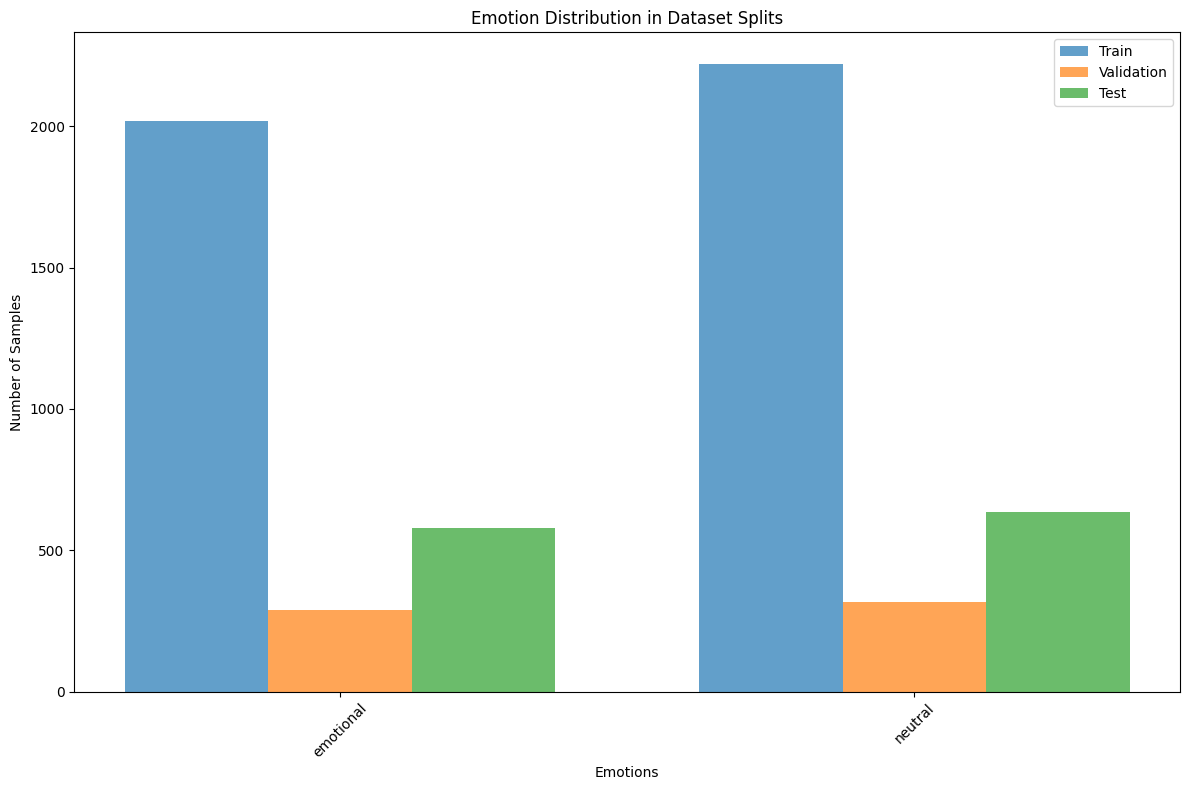


🚀 Preparing full dataset...
📁 Loading 13 feature files...
✅ Loaded 6059 feature vectors
📊 Feature Shape Analysis:
   last_hidden_state: (768,) - 6059 files
   hidden_states_mean: (1, 768) - 6059 files
   hidden_states_std: (1, 768) - 6059 files
🎭 Emotion Distribution:
   neutral: 3173
   emotional: 2886

🎯 Using 2 emotions: ['emotional', 'neutral']
📊 After filtering: 6059 samples
📈 Dataset Split:
   Train: 4241 samples
   Val: 909 samples
   Test: 909 samples
💾 Preprocessed data saved to: ./preprocessed_data

🎉 Data preparation completed!
📊 Final dataset stats:
   - Train samples: 4241
   - Validation samples: 909
   - Test samples: 909
   - Number of emotions: 2
   - Batch size: 32
   - Feature shape: torch.Size([32, 1, 100, 768])


In [ ]:
import numpy as np
import json
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

class IEMOCAPHuBERTDataset(Dataset):
    def __init__(self, features, labels, max_length=None, pad_value=0.0):
        """
        Dataset for IEMOCAP HuBERT features
        
        Args:
            features: List of feature arrays [batch_size, seq_len, 768]
            labels: List of emotion labels
            max_length: Maximum sequence length (pad or truncate to this)
            pad_value: Value to use for padding
        """
        self.features = features
        self.labels = labels
        self.max_length = max_length
        self.pad_value = pad_value
        
        # Preprocess features to handle variable lengths
        self.processed_features = self._preprocess_features()
        
    def _preprocess_features(self):
        """Preprocess features to handle variable sequence lengths"""
        processed = []
        
        for feature in self.features:
            # Handle different feature formats
            if isinstance(feature, dict):
                # If features are stored as dictionaries with different representations
                if 'last_hidden_state' in feature:
                    feat_array = np.array(feature['last_hidden_state'])
                else:
                    # Use the first available feature
                    feat_array = np.array(list(feature.values())[0])
            else:
                feat_array = np.array(feature)
            
            # Ensure 3D shape [1, seq_len, 768] or [seq_len, 768]
            if feat_array.ndim == 1:
                # If it's already mean-pooled [768], expand to [1, 1, 768]
                feat_array = feat_array.reshape(1, 1, -1)
            elif feat_array.ndim == 2:
                # [seq_len, 768] -> [1, seq_len, 768]
                feat_array = feat_array[np.newaxis, :, :]
            
            # Pad or truncate to max_length
            if self.max_length is not None:
                seq_len = feat_array.shape[1]
                if seq_len > self.max_length:
                    # Truncate
                    feat_array = feat_array[:, :self.max_length, :]
                elif seq_len < self.max_length:
                    # Pad
                    pad_width = ((0, 0), (0, self.max_length - seq_len), (0, 0))
                    feat_array = np.pad(feat_array, pad_width, 
                                      mode='constant', 
                                      constant_values=self.pad_value)
            
            processed.append(feat_array)
        
        return processed
    
    def __len__(self):
        return len(self.processed_features)
    
    def __getitem__(self, idx):
        feature = torch.FloatTensor(self.processed_features[idx])
        label = self.labels[idx]
        return feature, label

class HubertFeatureLoader:
    def __init__(self, features_dir="./iemocap_hubert_features"):
        self.features_dir = features_dir
        self.features_path = os.path.join(features_dir, "features")
        self.metadata_path = os.path.join(features_dir, "metadata")
        
    def load_all_features(self):
        """Load all HuBERT features and metadata"""
        if not os.path.exists(self.features_path):
            raise FileNotFoundError(f"Features directory not found: {self.features_path}")
            
        feature_files = [f for f in os.listdir(self.features_path) if f.endswith('_hubert.npy')]
        
        if not feature_files:
            raise FileNotFoundError("No feature files found!")
        
        all_features = []
        all_metadata = []
        all_emotions = []
        
        print(f"📁 Loading {len(feature_files)} feature files...")
        
        for feature_file in feature_files:
            try:
                # Load features
                features_data = np.load(os.path.join(self.features_path, feature_file), 
                                      allow_pickle=True).item()
                
                # Load corresponding metadata
                metadata_file = feature_file.replace('.npy', '_metadata.json')
                metadata_path = os.path.join(self.metadata_path, metadata_file)
                
                if os.path.exists(metadata_path):
                    with open(metadata_path, 'r') as f:
                        metadata = json.load(f)
                else:
                    print(f"⚠️ Metadata file not found: {metadata_file}")
                    continue
                
                all_features.extend(features_data['hubert_features'])
                all_metadata.extend(metadata)
                all_emotions.extend([m['emotion'] for m in metadata])
                
            except Exception as e:
                print(f"❌ Error loading {feature_file}: {e}")
                continue
        
        print(f"✅ Loaded {len(all_features)} feature vectors")
        return all_features, all_metadata, all_emotions
    
    def analyze_feature_shapes(self, features):
        """Analyze the shapes of loaded features"""
        shapes = []
        for feature in features:
            if isinstance(feature, dict):
                # Check each feature type in the dictionary
                for key, value in feature.items():
                    if hasattr(value, '__len__'):
                        shapes.append((key, np.array(value).shape))
            else:
                shapes.append(('raw', np.array(feature).shape))
        
        shape_counts = Counter(shapes)
        print("📊 Feature Shape Analysis:")
        for shape, count in shape_counts.most_common(10):
            print(f"   {shape[0]}: {shape[1]} - {count} files")
        
        return shape_counts

    def create_emotion_mapping(self, emotions):
        """Create emotion to label mapping, handling rare emotions"""
        emotion_counts = Counter(emotions)
        print("🎭 Emotion Distribution:")
        for emotion, count in emotion_counts.most_common():
            print(f"   {emotion}: {count}")
        
       
        valid_emotions = {emotion for emotion, count in emotion_counts.items() 
                         if count >= 50}
        
        # Create mapping
        emotion_mapping = {emotion: idx for idx, emotion in enumerate(sorted(valid_emotions))}
        
        print(f"\n🎯 Using {len(emotion_mapping)} emotions: {list(emotion_mapping.keys())}")
        
        return emotion_mapping

    def prepare_dataset(self, test_size=0.2, val_size=0.1, max_seq_length=100, 
                       random_state=42):
        """
        Prepare train/val/test splits from HuBERT features
        
        Args:
            test_size: Proportion for test set
            val_size: Proportion for validation set (from training set after test split)
            max_seq_length: Maximum sequence length for padding/truncation
            random_state: Random seed for reproducibility
        """
        # Load all features and metadata
        features, metadata, emotions = self.load_all_features()
        
        if not features:
            raise ValueError("No features loaded!")
        
        # Analyze feature shapes
        self.analyze_feature_shapes(features)
        
        # Create emotion mapping
        emotion_mapping = self.create_emotion_mapping(emotions)
        
        # Filter data to only include valid emotions
        valid_indices = []
        valid_features = []
        valid_emotions = []
        valid_metadata = []
        
        for i, (feature, meta, emotion) in enumerate(zip(features, metadata, emotions)):
            if emotion in emotion_mapping:
                valid_indices.append(i)
                valid_features.append(feature)
                valid_emotions.append(emotion)
                valid_metadata.append(meta)
        
        print(f"📊 After filtering: {len(valid_features)} samples")
        
        # Convert emotions to labels
        labels = [emotion_mapping[emotion] for emotion in valid_emotions]
        
        # First split: separate test set
        X_temp, X_test, y_temp, y_test, meta_temp, meta_test = train_test_split(
            valid_features, labels, valid_metadata,
            test_size=test_size,
            random_state=random_state,
            stratify=labels
        )
        
        # Second split: separate validation set from temporary training set
        val_size_adj = val_size / (1 - test_size)  # Adjust val_size for the remaining data
        X_train, X_val, y_train, y_val, meta_train, meta_val = train_test_split(
            X_temp, y_temp, meta_temp,
            test_size=val_size_adj,
            random_state=random_state,
            stratify=y_temp
        )
        
        print(f"📈 Dataset Split:")
        print(f"   Train: {len(X_train)} samples")
        print(f"   Val: {len(X_val)} samples")
        print(f"   Test: {len(X_test)} samples")
        
        # Create datasets
        train_dataset = IEMOCAPHuBERTDataset(X_train, y_train, max_length=max_seq_length)
        val_dataset = IEMOCAPHuBERTDataset(X_val, y_val, max_length=max_seq_length)
        test_dataset = IEMOCAPHuBERTDataset(X_test, y_test, max_length=max_seq_length)
        
        return {
            'train': train_dataset,
            'val': val_dataset,
            'test': test_dataset,
            'emotion_mapping': emotion_mapping,
            'metadata': {
                'train': meta_train,
                'val': meta_val,
                'test': meta_test
            }
        }

def analyze_dataset_splits(datasets, emotion_mapping):
    """Analyze and visualize the dataset splits"""
    # Reverse emotion mapping for display
    id_to_emotion = {v: k for k, v in emotion_mapping.items()}
    
    # Count labels in each split
    train_labels = [label for _, label in datasets['train']]
    val_labels = [label for _, label in datasets['val']]
    test_labels = [label for _, label in datasets['test']]
    
    train_counts = Counter(train_labels)
    val_counts = Counter(val_labels)
    test_counts = Counter(test_labels)
    
    print("\n📊 Label Distribution in Splits:")
    print("Emotion".ljust(15) + "Train".ljust(10) + "Val".ljust(10) + "Test".ljust(10))
    print("-" * 45)
    
    for emotion_id, emotion_name in id_to_emotion.items():
        train_count = train_counts.get(emotion_id, 0)
        val_count = val_counts.get(emotion_id, 0)
        test_count = test_counts.get(emotion_id, 0)
        print(f"{emotion_name.ljust(15)}{str(train_count).ljust(10)}{str(val_count).ljust(10)}{str(test_count).ljust(10)}")
    
    # Plot distribution
    plt.figure(figsize=(12, 8))
    
    # Prepare data for plotting
    emotions = [id_to_emotion[i] for i in sorted(id_to_emotion.keys())]
    train_counts_list = [train_counts.get(i, 0) for i in sorted(id_to_emotion.keys())]
    val_counts_list = [val_counts.get(i, 0) for i in sorted(id_to_emotion.keys())]
    test_counts_list = [test_counts.get(i, 0) for i in sorted(id_to_emotion.keys())]
    
    x = np.arange(len(emotions))
    width = 0.25
    
    plt.bar(x - width, train_counts_list, width, label='Train', alpha=0.7)
    plt.bar(x, val_counts_list, width, label='Validation', alpha=0.7)
    plt.bar(x + width, test_counts_list, width, label='Test', alpha=0.7)
    
    plt.xlabel('Emotions')
    plt.ylabel('Number of Samples')
    plt.title('Emotion Distribution in Dataset Splits')
    plt.xticks(x, emotions, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

def create_data_loaders(datasets, batch_size=32, shuffle_train=True):
    """Create DataLoader objects for training"""
    train_loader = DataLoader(
        datasets['train'], 
        batch_size=batch_size, 
        shuffle=shuffle_train,
        num_workers=0  # Set to 0 for Windows compatibility
    )
    
    val_loader = DataLoader(
        datasets['val'], 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=0
    )
    
    test_loader = DataLoader(
        datasets['test'], 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=0
    )
    
    return {
        'train': train_loader,
        'val': val_loader,
        'test': test_loader
    }

def test_data_loading(batch_size=4):
    """Test function to verify data loading works correctly"""
    print("🧪 Testing data loading...")
    
    try:
        loader = HubertFeatureLoader()
        datasets = loader.prepare_dataset(max_seq_length=50)  # Use smaller seq length for testing
        
        # Test dataset sizes
        print(f"✅ Dataset sizes - Train: {len(datasets['train'])}, "
              f"Val: {len(datasets['val'])}, Test: {len(datasets['test'])}")
        
        # Test one batch
        data_loaders = create_data_loaders(datasets, batch_size=batch_size)
        
        # Get one batch from train loader
        for features, labels in data_loaders['train']:
            print(f"✅ Batch features shape: {features.shape}")  # [batch_size, 1, seq_len, 768]
            print(f"✅ Batch labels shape: {labels.shape}")      # [batch_size]
            print(f"✅ Feature range: [{features.min():.3f}, {features.max():.3f}]")
            break
        
        # Analyze splits
        analyze_dataset_splits(datasets, datasets['emotion_mapping'])
        
        return datasets, data_loaders
        
    except Exception as e:
        print(f"❌ Error in data loading test: {e}")
        return None, None

def save_preprocessed_data(datasets, data_loaders, output_dir="./preprocessed_data"):
    """Save preprocessed datasets for future use"""
    os.makedirs(output_dir, exist_ok=True)
    
    # Save datasets
    torch.save(datasets['train'], os.path.join(output_dir, "train_dataset.pt"))
    torch.save(datasets['val'], os.path.join(output_dir, "val_dataset.pt"))
    torch.save(datasets['test'], os.path.join(output_dir, "test_dataset.pt"))
    
    # Save emotion mapping
    with open(os.path.join(output_dir, "emotion_mapping.json"), 'w') as f:
        json.dump(datasets['emotion_mapping'], f, indent=2)
    
    # Save metadata
    with open(os.path.join(output_dir, "split_metadata.json"), 'w') as f:
        json.dump(datasets['metadata'], f, indent=2)
    
    # Save dataset info
    dataset_info = {
        'train_size': len(datasets['train']),
        'val_size': len(datasets['val']),
        'test_size': len(datasets['test']),
        'feature_shape': next(iter(data_loaders['train']))[0].shape,
        'num_classes': len(datasets['emotion_mapping']),
        'emotions': list(datasets['emotion_mapping'].keys())
    }
    
    with open(os.path.join(output_dir, "dataset_info.json"), 'w') as f:
        json.dump(dataset_info, f, indent=2)
    
    print(f"💾 Preprocessed data saved to: {output_dir}")
    return output_dir

def main():
    """Main function to prepare HuBERT features for training"""
    print("🎵 Preparing IEMOCAP HuBERT Features for Training")
    print("=" * 60)
    
    try:
        # Test data loading with small batch
        datasets, data_loaders = test_data_loading(batch_size=8)
        
        if datasets is None:
            print("❌ Data preparation failed!")
            return
        
        print("\n🚀 Preparing full dataset...")
        
        # Prepare full dataset with optimal parameters
        loader = HubertFeatureLoader()
        full_datasets = loader.prepare_dataset(
            test_size=0.15,      # 15% test
            val_size=0.15,       # 15% validation
            max_seq_length=100,  # Reasonable sequence length
            random_state=42
        )
        
        # Create data loaders
        full_data_loaders = create_data_loaders(
            full_datasets, 
            batch_size=32,       # Standard batch size
            shuffle_train=True
        )
        
        # Save preprocessed data
        save_preprocessed_data(full_datasets, full_data_loaders)
        
        print(f"\n🎉 Data preparation completed!")
        print(f"📊 Final dataset stats:")
        print(f"   - Train samples: {len(full_datasets['train'])}")
        print(f"   - Validation samples: {len(full_datasets['val'])}")
        print(f"   - Test samples: {len(full_datasets['test'])}")
        print(f"   - Number of emotions: {len(full_datasets['emotion_mapping'])}")
        print(f"   - Batch size: 32")
        print(f"   - Feature shape: {next(iter(full_data_loaders['train']))[0].shape}")
        
        return full_datasets, full_data_loaders
        
    except Exception as e:
        print(f"❌ Error in main preparation: {e}")
        import traceback
        traceback.print_exc()
        return None, None

if __name__ == "__main__":
    datasets, data_loaders = main()

🧪 Testing model forward pass...
Input shape: torch.Size([4, 1, 50, 768])
Output logits shape: torch.Size([4, 2])
Attention weights shape: torch.Size([4, 4, 50, 50])
✅ Model forward pass successful!

🎵 Training Emotion Classification Model
📱 Using device: cpu
📦 Loading HuBERT features directly...
📁 Loading 13 feature files directly...
✅ Loaded 6059 feature vectors
🎭 Emotion Distribution:
   neutral: 3173
   emotional: 2886

🎯 Using 2 emotions: ['emotional', 'neutral']
📈 Dataset Split:
   Train: 4241 samples
   Val: 909 samples
   Test: 909 samples
🎯 Number of classes: 2
📦 Emotions: ['emotional', 'neutral']

🔢 Model Parameters:
  Total parameters: 4,212,546
  Trainable parameters: 4,212,546
  Non-trainable parameters: 0

🏗️  Model Architecture:
EmotionTransformer(
  (input_projection): Linear(in_features=768, out_features=256, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention

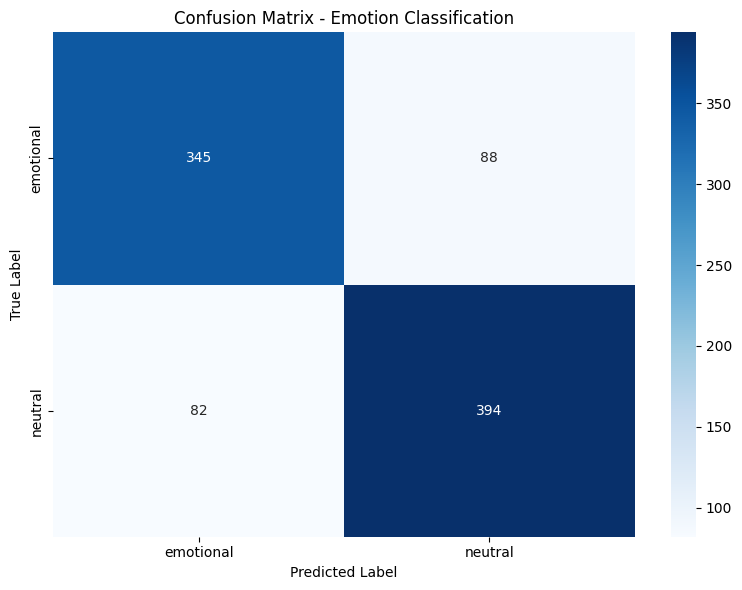

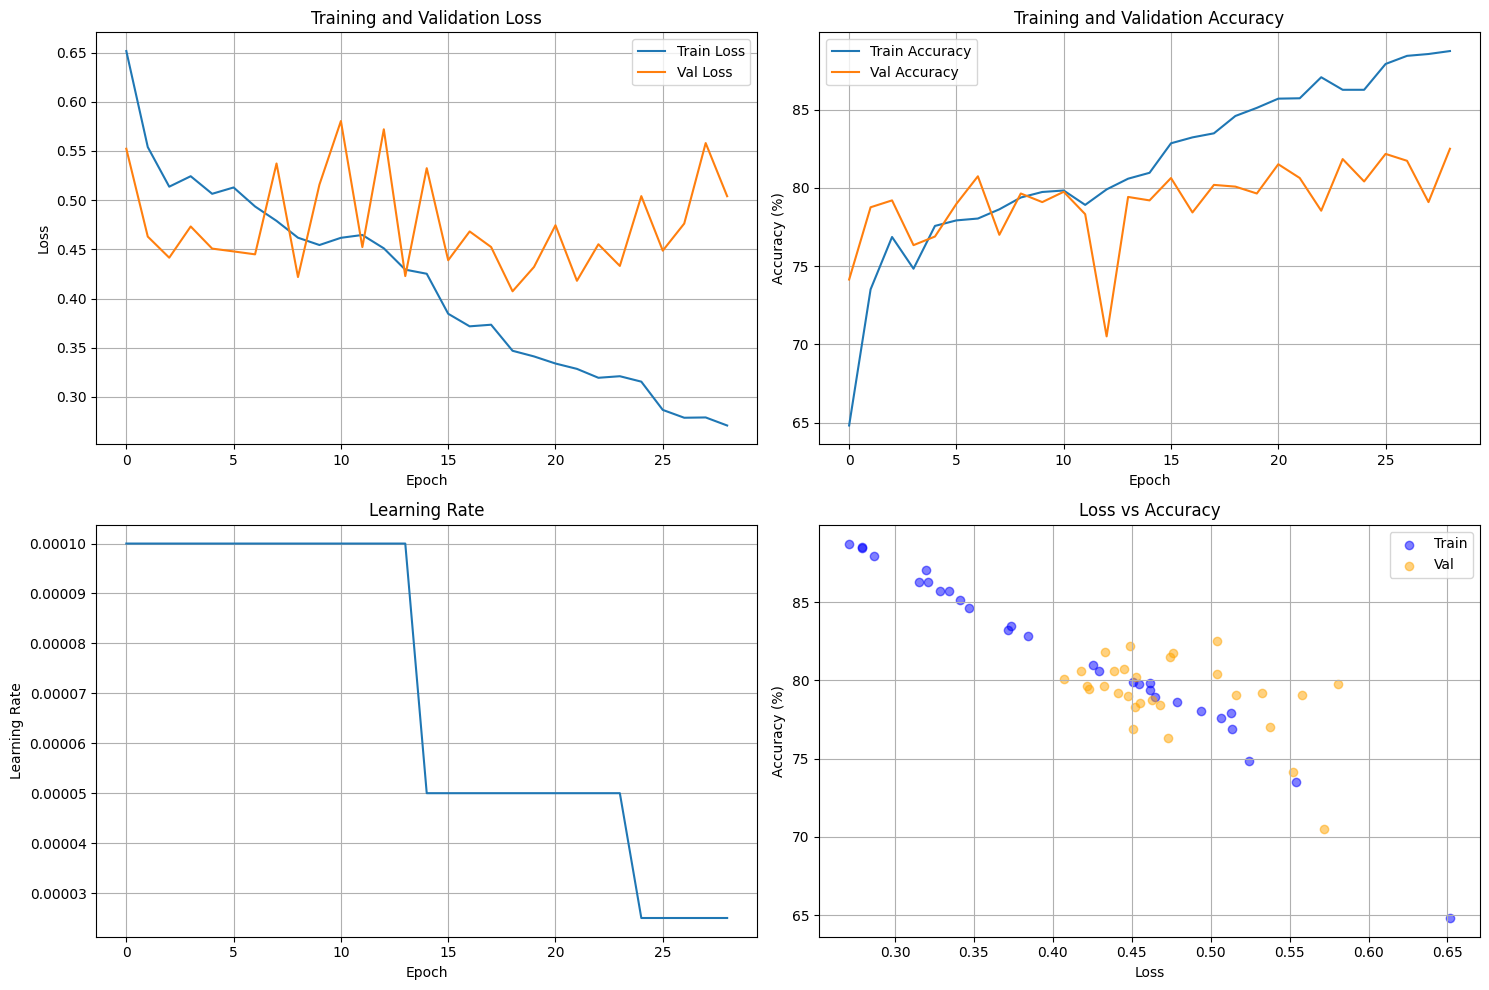


🎉 Training completed!
📊 Final Test Accuracy: 81.30%


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import time
import json
import os
from sklearn.model_selection import train_test_split
from collections import Counter

# Redefine the dataset class to ensure it's available
class IEMOCAPHuBERTDataset(Dataset):
    def __init__(self, features, labels, max_length=None, pad_value=0.0):
        """
        Dataset for IEMOCAP HuBERT features
        
        Args:
            features: List of feature arrays [batch_size, seq_len, 768]
            labels: List of emotion labels
            max_length: Maximum sequence length (pad or truncate to this)
            pad_value: Value to use for padding
        """
        self.features = features
        self.labels = labels
        self.max_length = max_length
        self.pad_value = pad_value
        
        # Preprocess features to handle variable lengths
        self.processed_features = self._preprocess_features()
        
    def _preprocess_features(self):
        """Preprocess features to handle variable sequence lengths"""
        processed = []
        
        for feature in self.features:
            # Handle different feature formats
            if isinstance(feature, dict):
                # If features are stored as dictionaries with different representations
                if 'last_hidden_state' in feature:
                    feat_array = np.array(feature['last_hidden_state'])
                else:
                    # Use the first available feature
                    feat_array = np.array(list(feature.values())[0])
            else:
                feat_array = np.array(feature)
            
            # Ensure 3D shape [1, seq_len, 768] or [seq_len, 768]
            if feat_array.ndim == 1:
                # If it's already mean-pooled [768], expand to [1, 1, 768]
                feat_array = feat_array.reshape(1, 1, -1)
            elif feat_array.ndim == 2:
                # [seq_len, 768] -> [1, seq_len, 768]
                feat_array = feat_array[np.newaxis, :, :]
            
            # Pad or truncate to max_length
            if self.max_length is not None:
                seq_len = feat_array.shape[1]
                if seq_len > self.max_length:
                    # Truncate
                    feat_array = feat_array[:, :self.max_length, :]
                elif seq_len < self.max_length:
                    # Pad
                    pad_width = ((0, 0), (0, self.max_length - seq_len), (0, 0))
                    feat_array = np.pad(feat_array, pad_width, 
                                      mode='constant', 
                                      constant_values=self.pad_value)
            
            processed.append(feat_array)
        
        return processed
    
    def __len__(self):
        return len(self.processed_features)
    
    def __getitem__(self, idx):
        feature = torch.FloatTensor(self.processed_features[idx])
        label = self.labels[idx]
        return feature, label

class TemporalAttentionPooling(nn.Module):
    """Attention-based temporal pooling to get fixed-size representations"""
    def __init__(self, hidden_dim, num_heads=8, dropout=0.1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.head_dim = hidden_dim // num_heads
        
        # Multi-head attention for temporal pooling
        self.query = nn.Linear(hidden_dim, hidden_dim)
        self.key = nn.Linear(hidden_dim, hidden_dim)
        self.value = nn.Linear(hidden_dim, hidden_dim)
        self.attention_dropout = nn.Dropout(dropout)
        self.output_projection = nn.Linear(hidden_dim, hidden_dim)
        
        # Layer normalization
        self.layer_norm1 = nn.LayerNorm(hidden_dim)
        self.layer_norm2 = nn.LayerNorm(hidden_dim)
        
        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 4, hidden_dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        # x shape: [batch_size, seq_len, hidden_dim]
        batch_size, seq_len, hidden_dim = x.shape
        
        # Generate queries, keys, values
        Q = self.query(x)  # [batch_size, seq_len, hidden_dim]
        K = self.key(x)    # [batch_size, seq_len, hidden_dim]
        V = self.value(x)  # [batch_size, seq_len, hidden_dim]
        
        # Reshape for multi-head attention
        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        
        # Compute attention scores
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_weights = self.attention_dropout(attention_weights)
        
        # Apply attention to values
        attention_output = torch.matmul(attention_weights, V)
        attention_output = attention_output.transpose(1, 2).contiguous().view(
            batch_size, seq_len, hidden_dim
        )
        
        # Residual connection and layer norm
        attention_output = self.output_projection(attention_output)
        x = self.layer_norm1(x + attention_output)
        
        # Feed-forward with residual connection
        ffn_output = self.ffn(x)
        x = self.layer_norm2(x + ffn_output)
        
        # Global average pooling over time dimension
        pooled_output = x.mean(dim=1)  # [batch_size, hidden_dim]
        
        return pooled_output, attention_weights

class EmotionTransformer(nn.Module):
    """Transformer-based emotion classification model for HuBERT features"""
    
    def __init__(self, input_dim=768, hidden_dim=256, num_layers=4, num_heads=8, 
                 num_classes=2, dropout=0.2, max_seq_length=100):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_classes = num_classes
        
        # Input projection to match hidden dimension
        self.input_projection = nn.Linear(input_dim, hidden_dim)
        
        # Positional encoding
        self.positional_encoding = nn.Parameter(
            torch.zeros(1, max_seq_length, hidden_dim)
        )
        
        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, 
            num_layers=num_layers
        )
        
        # Temporal attention pooling
        self.temporal_pooling = TemporalAttentionPooling(
            hidden_dim=hidden_dim,
            num_heads=num_heads,
            dropout=dropout
        )
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 4, num_classes)
        )
        
        # Initialize weights
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.constant_(module.bias, 0)
            torch.nn.init.constant_(module.weight, 1.0)
        elif isinstance(module, nn.Parameter):
            torch.nn.init.normal_(module, mean=0.0, std=0.02)
    
    def forward(self, x):
        # x shape: [batch_size, 1, seq_len, input_dim]
        # Remove the extra dimension
        x = x.squeeze(1)  # [batch_size, seq_len, input_dim]
        
        # Project input to hidden dimension
        x = self.input_projection(x)  # [batch_size, seq_len, hidden_dim]
        
        # Add positional encoding
        seq_len = x.size(1)
        x = x + self.positional_encoding[:, :seq_len, :]
        
        # Apply transformer encoder
        x = self.transformer_encoder(x)  # [batch_size, seq_len, hidden_dim]
        
        # Apply temporal attention pooling
        pooled_output, attention_weights = self.temporal_pooling(x)
        
        # Classification
        logits = self.classifier(pooled_output)  # [batch_size, num_classes]
        
        return logits, attention_weights

class HubertFeatureLoader:
    """Loader for HuBERT features that avoids the serialization issue"""
    
    def __init__(self, features_dir="./iemocap_hubert_features"):
        self.features_dir = features_dir
        self.features_path = os.path.join(features_dir, "features")
        self.metadata_path = os.path.join(features_dir, "metadata")
        
    def load_features_directly(self):
        """Load features directly from numpy files without serialization"""
        if not os.path.exists(self.features_path):
            raise FileNotFoundError(f"Features directory not found: {self.features_path}")
            
        feature_files = [f for f in os.listdir(self.features_path) if f.endswith('_hubert.npy')]
        
        if not feature_files:
            raise FileNotFoundError("No feature files found!")
        
        all_features = []
        all_emotions = []
        
        print(f"📁 Loading {len(feature_files)} feature files directly...")
        
        for feature_file in feature_files:
            try:
                # Load features
                features_data = np.load(os.path.join(self.features_path, feature_file), 
                                      allow_pickle=True).item()
                
                # Load corresponding metadata
                metadata_file = feature_file.replace('.npy', '_metadata.json')
                metadata_path = os.path.join(self.metadata_path, metadata_file)
                
                if os.path.exists(metadata_path):
                    with open(metadata_path, 'r') as f:
                        metadata = json.load(f)
                else:
                    print(f"⚠️ Metadata file not found: {metadata_file}")
                    continue
                
                all_features.extend(features_data['hubert_features'])
                all_emotions.extend([m['emotion'] for m in metadata])
                
            except Exception as e:
                print(f"❌ Error loading {feature_file}: {e}")
                continue
        
        print(f"✅ Loaded {len(all_features)} feature vectors")
        return all_features, all_emotions
    
    def create_emotion_mapping(self, emotions):
        """Create emotion to label mapping"""
        emotion_counts = Counter(emotions)
        print("🎭 Emotion Distribution:")
        for emotion, count in emotion_counts.most_common():
            print(f"   {emotion}: {count}")
        
        # Create mapping
        emotion_mapping = {emotion: idx for idx, emotion in enumerate(sorted(set(emotions)))}
        
        print(f"\n🎯 Using {len(emotion_mapping)} emotions: {list(emotion_mapping.keys())}")
        
        return emotion_mapping
    
    def prepare_datasets_directly(self, test_size=0.15, val_size=0.15, max_seq_length=100, 
                                random_state=42):
        """Prepare datasets directly from features without saving/loading"""
        # Load features directly
        features, emotions = self.load_features_directly()
        
        if not features:
            raise ValueError("No features loaded!")
        
        # Create emotion mapping
        emotion_mapping = self.create_emotion_mapping(emotions)
        
        # Convert emotions to labels
        labels = [emotion_mapping[emotion] for emotion in emotions]
        
        # First split: separate test set
        X_temp, X_test, y_temp, y_test = train_test_split(
            features, labels,
            test_size=test_size,
            random_state=random_state,
            stratify=labels
        )
        
        # Second split: separate validation set from temporary training set
        val_size_adj = val_size / (1 - test_size)  # Adjust val_size for the remaining data
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp,
            test_size=val_size_adj,
            random_state=random_state,
            stratify=y_temp
        )
        
        print(f"📈 Dataset Split:")
        print(f"   Train: {len(X_train)} samples")
        print(f"   Val: {len(X_val)} samples")
        print(f"   Test: {len(X_test)} samples")
        
        # Create datasets
        train_dataset = IEMOCAPHuBERTDataset(X_train, y_train, max_length=max_seq_length)
        val_dataset = IEMOCAPHuBERTDataset(X_val, y_val, max_length=max_seq_length)
        test_dataset = IEMOCAPHuBERTDataset(X_test, y_test, max_length=max_seq_length)
        
        return {
            'train': train_dataset,
            'val': val_dataset,
            'test': test_dataset,
            'emotion_mapping': emotion_mapping
        }

class EmotionTrainer:
    """Trainer class for emotion classification model"""
    
    def __init__(self, model, train_loader, val_loader, test_loader, 
                 device='cuda', learning_rate=1e-4, weight_decay=1e-4):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Loss function with class weighting
        self.criterion = nn.CrossEntropyLoss()
        
        # Optimizer
        self.optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=learning_rate, 
            weight_decay=weight_decay
        )
        
        # Learning rate scheduler - FIXED: removed 'verbose' parameter
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', patience=5, factor=0.5
        )
        
        # Training history
        self.history = {
            'train_loss': [], 'val_loss': [],
            'train_acc': [], 'val_acc': [],
            'learning_rates': []
        }
    
    def train_epoch(self):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for batch_idx, (features, labels) in enumerate(self.train_loader):
            features = features.to(self.device)
            labels = labels.to(self.device)
            
            # Forward pass
            self.optimizer.zero_grad()
            logits, _ = self.model(features)
            loss = self.criterion(logits, labels)
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            
            # Statistics
            total_loss += loss.item()
            _, predicted = logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            if batch_idx % 50 == 0:
                print(f'  Batch {batch_idx}/{len(self.train_loader)}, '
                      f'Loss: {loss.item():.4f}')
        
        epoch_loss = total_loss / len(self.train_loader)
        epoch_acc = 100. * correct / total
        
        return epoch_loss, epoch_acc
    
    def validate(self, loader):
        """Validate on given data loader"""
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0
        all_predictions = []
        all_labels = []
        
        with torch.no_grad():
            for features, labels in loader:
                features = features.to(self.device)
                labels = labels.to(self.device)
                
                logits, _ = self.model(features)
                loss = self.criterion(logits, labels)
                
                total_loss += loss.item()
                _, predicted = logits.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        epoch_loss = total_loss / len(loader)
        epoch_acc = 100. * correct / total
        
        return epoch_loss, epoch_acc, all_predictions, all_labels
    
    def train(self, num_epochs=50, early_stopping_patience=10):
        """Full training loop"""
        print("🚀 Starting training...")
        best_val_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(num_epochs):
            start_time = time.time()
            
            # Train
            train_loss, train_acc = self.train_epoch()
            
            # Validate
            val_loss, val_acc, _, _ = self.validate(self.val_loader)
            
            # Update learning rate
            self.scheduler.step(val_loss)
            current_lr = self.optimizer.param_groups[0]['lr']
            
            # Record history
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_acc'].append(val_acc)
            self.history['learning_rates'].append(current_lr)
            
            epoch_time = time.time() - start_time
            
            print(f'Epoch {epoch+1}/{num_epochs} - {epoch_time:.1f}s')
            print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
            print(f'  LR: {current_lr:.2e}')
            
            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # Save best model
                torch.save(self.model.state_dict(), 'best_emotion_model.pth')
                print('  💾 New best model saved!')
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f'  🛑 Early stopping after {epoch+1} epochs')
                    break
            
            print('-' * 60)
        
        # Load best model
        self.model.load_state_dict(torch.load('best_emotion_model.pth'))
        print('✅ Training completed!')
    
    def evaluate(self, emotion_mapping):
        """Comprehensive evaluation on test set"""
        print("\n🧪 Evaluating on test set...")
        
        test_loss, test_acc, predictions, true_labels = self.validate(self.test_loader)
        
        # Convert numeric labels to emotion names
        id_to_emotion = {v: k for k, v in emotion_mapping.items()}
        emotion_names = [id_to_emotion[i] for i in sorted(id_to_emotion.keys())]
        
        # Classification report
        print(f"\n📊 Test Results:")
        print(f"  Loss: {test_loss:.4f}")
        print(f"  Accuracy: {test_acc:.2f}%")
        
        print(f"\n📈 Classification Report:")
        print(classification_report(true_labels, predictions, 
                                  target_names=emotion_names, digits=4))
        
        # Confusion matrix
        cm = confusion_matrix(true_labels, predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=emotion_names, yticklabels=emotion_names)
        plt.title('Confusion Matrix - Emotion Classification')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
        
        return test_acc, test_loss
    
    def plot_training_history(self):
        """Plot training history"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Loss
        ax1.plot(self.history['train_loss'], label='Train Loss')
        ax1.plot(self.history['val_loss'], label='Val Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Accuracy
        ax2.plot(self.history['train_acc'], label='Train Accuracy')
        ax2.plot(self.history['val_acc'], label='Val Accuracy')
        ax2.set_title('Training and Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid(True)
        
        # Learning rate
        ax3.plot(self.history['learning_rates'])
        ax3.set_title('Learning Rate')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Learning Rate')
        ax3.grid(True)
        
        # Loss vs Accuracy
        ax4.scatter(self.history['train_loss'], self.history['train_acc'], 
                   alpha=0.5, label='Train', c='blue')
        ax4.scatter(self.history['val_loss'], self.history['val_acc'], 
                   alpha=0.5, label='Val', c='orange')
        ax4.set_xlabel('Loss')
        ax4.set_ylabel('Accuracy (%)')
        ax4.set_title('Loss vs Accuracy')
        ax4.legend()
        ax4.grid(True)
        
        plt.tight_layout()
        plt.show()

def analyze_model_complexity(model):
    """Analyze model complexity"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\n🔢 Model Parameters:")
    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")
    print(f"  Non-trainable parameters: {total_params - trainable_params:,}")
    
    # Print model structure
    print(f"\n🏗️  Model Architecture:")
    print(model)

def main_training():
    """Main training function that loads data directly"""
    print("🎵 Training Emotion Classification Model")
    print("=" * 60)
    
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"📱 Using device: {device}")
    
    # Load data directly
    print("📦 Loading HuBERT features directly...")
    loader = HubertFeatureLoader()
    datasets = loader.prepare_datasets_directly(
        test_size=0.15,
        val_size=0.15, 
        max_seq_length=100,
        random_state=42
    )
    
    # Create data loaders
    data_loaders = {
        'train': DataLoader(datasets['train'], batch_size=32, shuffle=True, num_workers=0),
        'val': DataLoader(datasets['val'], batch_size=32, shuffle=False, num_workers=0),
        'test': DataLoader(datasets['test'], batch_size=32, shuffle=False, num_workers=0)
    }
    
    # Model configuration
    num_classes = len(datasets['emotion_mapping'])
    print(f"🎯 Number of classes: {num_classes}")
    print(f"📦 Emotions: {list(datasets['emotion_mapping'].keys())}")
    
    # Create model
    model = EmotionTransformer(
        input_dim=768,
        hidden_dim=256,
        num_layers=4,
        num_heads=8,
        num_classes=num_classes,
        dropout=0.2,
        max_seq_length=100
    )
    
    # Analyze model
    analyze_model_complexity(model)
    
    # Create trainer
    trainer = EmotionTrainer(
        model=model,
        train_loader=data_loaders['train'],
        val_loader=data_loaders['val'],
        test_loader=data_loaders['test'],
        device=device,
        learning_rate=1e-4,
        weight_decay=1e-4
    )
    
    # Train model
    trainer.train(num_epochs=50, early_stopping_patience=10)
    
    # Evaluate model
    test_acc, test_loss = trainer.evaluate(datasets['emotion_mapping'])
    
    # Plot training history
    trainer.plot_training_history()
    
    # Save training results
    results = {
        'test_accuracy': test_acc,
        'test_loss': test_loss,
        'num_classes': num_classes,
        'emotions': list(datasets['emotion_mapping'].keys()),
        'model_parameters': sum(p.numel() for p in model.parameters()),
        'training_history': {
            'train_loss': trainer.history['train_loss'],
            'val_loss': trainer.history['val_loss'],
            'train_acc': trainer.history['train_acc'],
            'val_acc': trainer.history['val_acc']
        }
    }
    
    with open('training_results.json', 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"\n🎉 Training completed!")
    print(f"📊 Final Test Accuracy: {test_acc:.2f}%")
    
    return trainer

# Quick test function
def test_model_forward_pass():
    """Test model forward pass with sample data"""
    print("🧪 Testing model forward pass...")
    
    # Create a small model
    model = EmotionTransformer(
        input_dim=768,
        hidden_dim=128,  # Smaller for testing
        num_layers=2,
        num_heads=4,
        num_classes=2,
        max_seq_length=50
    )
    
    # Test input
    batch_size, seq_len = 4, 50
    test_input = torch.randn(batch_size, 1, seq_len, 768)
    
    print(f"Input shape: {test_input.shape}")
    
    # Forward pass
    with torch.no_grad():
        logits, attention_weights = model(test_input)
    
    print(f"Output logits shape: {logits.shape}")
    print(f"Attention weights shape: {attention_weights.shape}")
    print(f"✅ Model forward pass successful!")

if __name__ == "__main__":
    # Test model first
    test_model_forward_pass()
    
    print("\n" + "="*60)
    
    # Start full training
    trainer = main_training()

🎵 Training Emotion Classification Model with LABEL SMOOTHING
📱 Using device: cpu
📦 Loading HuBERT features directly...
📁 Loading 13 feature files directly...
✅ Loaded 6059 feature vectors
🎭 Emotion Distribution:
   neutral: 3173
   emotional: 2886

🎯 Using 2 emotions: ['emotional', 'neutral']
📈 Dataset Split:
   Train: 4241 samples
   Val: 909 samples
   Test: 909 samples
🎯 Number of classes: 2
📦 Emotions: ['emotional', 'neutral']

🔢 Model Parameters:
  Total parameters: 4,212,546
  Trainable parameters: 4,212,546
  Non-trainable parameters: 0

🏗️  Model Architecture:
EmotionTransformer(
  (input_projection): Linear(in_features=768, out_features=256, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=1024, bias

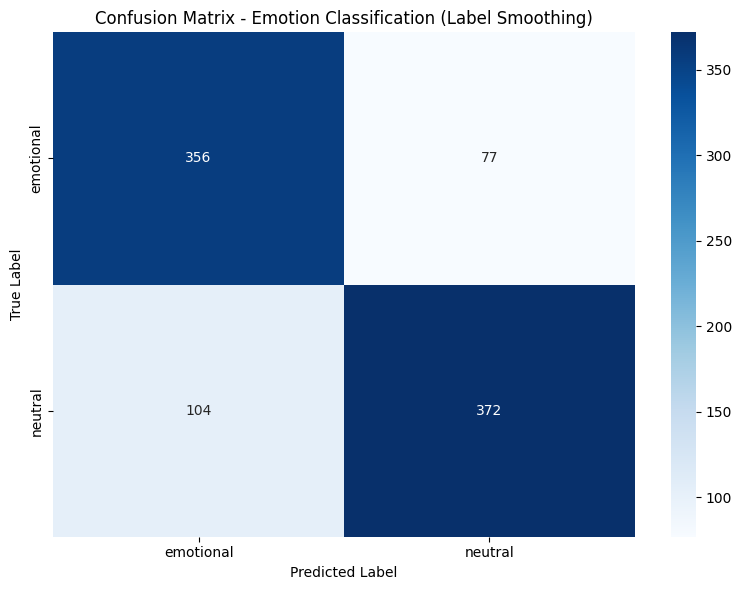

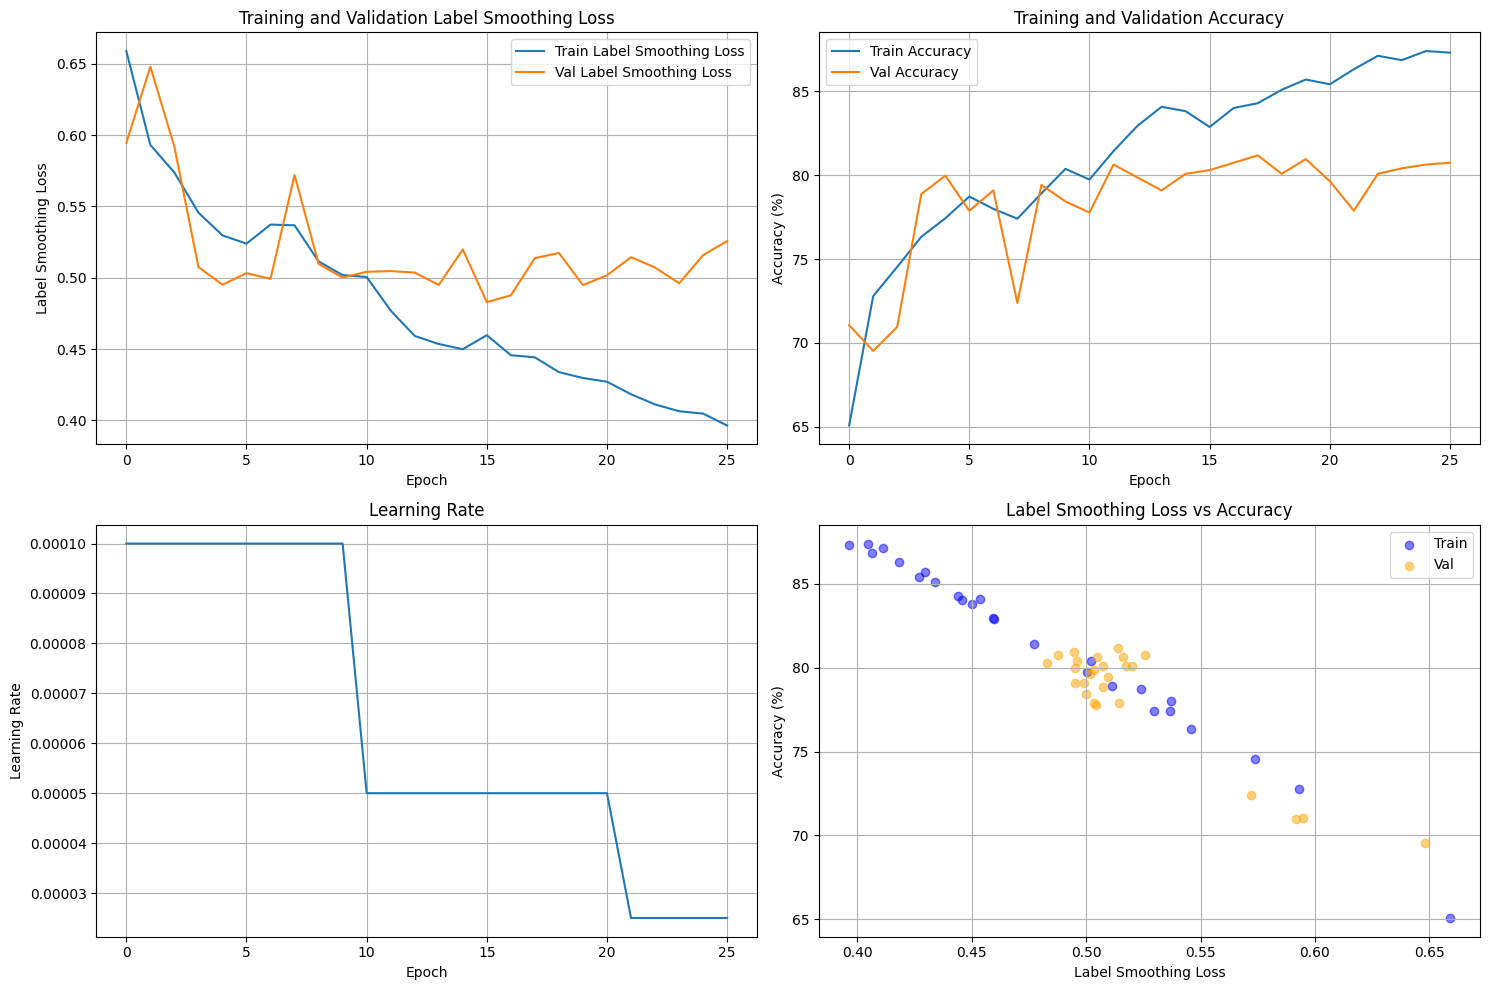


🎉 Training with Label Smoothing completed!
📊 Final Test Accuracy: 80.09%


In [11]:
import torch
import torch.nn as  nn
import torch.nn.functional as F

class LabelSmoothingCrossEntropy(nn.Module):
    """Label Smoothing Cross-Entropy for handling ambiguous emotions"""
    def __init__(self, smoothing=0.1, reduction='mean'):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Get number of classes
        num_classes = inputs.size(-1)
        
        # Convert targets to one-hot encoding
        one_hot = torch.zeros_like(inputs)
        one_hot.scatter_(1, targets.unsqueeze(1), 1.0)
        
        # Apply label smoothing
        smooth_labels = one_hot * (1 - self.smoothing) + self.smoothing / num_classes
        
        # Calculate cross entropy with smoothed labels
        log_probs = F.log_softmax(inputs, dim=-1)
        loss = -(smooth_labels * log_probs).sum(dim=-1)
        
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

class EmotionTrainerWithLabelSmoothing:
    """Trainer class with Label Smoothing for emotion classification"""
    
    def __init__(self, model, train_loader, val_loader, test_loader, 
                 device='cuda', learning_rate=1e-4, weight_decay=1e-4,
                 smoothing=0.1):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Label Smoothing CrossEntropy instead of standard CrossEntropy
        self.criterion = LabelSmoothingCrossEntropy(smoothing=smoothing)
        
        # Optimizer
        self.optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=learning_rate, 
            weight_decay=weight_decay
        )
        
        # Learning rate scheduler
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', patience=5, factor=0.5
        )
        
        # Training history
        self.history = {
            'train_loss': [], 'val_loss': [],
            'train_acc': [], 'val_acc': [],
            'learning_rates': []
        }

    def train_epoch(self):
        """Train for one epoch with Label Smoothing"""
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for batch_idx, (features, labels) in enumerate(self.train_loader):
            features = features.to(self.device)
            labels = labels.to(self.device)
            
            # Forward pass
            self.optimizer.zero_grad()
            logits, _ = self.model(features)
            loss = self.criterion(logits, labels)
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            
            # Statistics (use hard labels for accuracy calculation)
            total_loss += loss.item()
            _, predicted = logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            if batch_idx % 50 == 0:
                print(f'  Batch {batch_idx}/{len(self.train_loader)}, '
                      f'Label Smoothing Loss: {loss.item():.4f}')
        
        epoch_loss = total_loss / len(self.train_loader)
        epoch_acc = 100. * correct / total
        
        return epoch_loss, epoch_acc

    def validate(self, loader):
        """Validate on given data loader"""
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0
        all_predictions = []
        all_labels = []
        
        with torch.no_grad():
            for features, labels in loader:
                features = features.to(self.device)
                labels = labels.to(self.device)
                
                logits, _ = self.model(features)
                loss = self.criterion(logits, labels)
                
                total_loss += loss.item()
                _, predicted = logits.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        epoch_loss = total_loss / len(loader)
        epoch_acc = 100. * correct / total
        
        return epoch_loss, epoch_acc, all_predictions, all_labels

    def train(self, num_epochs=50, early_stopping_patience=10):
        """Full training loop with Label Smoothing"""
        print("🚀 Starting training with Label Smoothing Cross-Entropy...")
        print(f"📊 Label Smoothing parameter: smoothing={self.criterion.smoothing}")
        
        best_val_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(num_epochs):
            start_time = time.time()
            
            # Train with Label Smoothing
            train_loss, train_acc = self.train_epoch()
            
            # Validate
            val_loss, val_acc, _, _ = self.validate(self.val_loader)
            
            # Update learning rate
            self.scheduler.step(val_loss)
            current_lr = self.optimizer.param_groups[0]['lr']
            
            # Record history
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_acc'].append(val_acc)
            self.history['learning_rates'].append(current_lr)
            
            epoch_time = time.time() - start_time
            
            print(f'Epoch {epoch+1}/{num_epochs} - {epoch_time:.1f}s')
            print(f'  Train Label Smoothing Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'  Val Label Smoothing Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
            print(f'  LR: {current_lr:.2e}')
            
            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # Save best model
                torch.save(self.model.state_dict(), 'best_emotion_model_label_smoothing.pth')
                print('  💾 New best model saved!')
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f'  🛑 Early stopping after {epoch+1} epochs')
                    break
            
            print('-' * 60)
        
        # Load best model
        self.model.load_state_dict(torch.load('best_emotion_model_label_smoothing.pth'))
        print('✅ Training with Label Smoothing completed!')

    def evaluate(self, emotion_mapping):
        """Comprehensive evaluation on test set"""
        print("\n🧪 Evaluating on test set with Label Smoothing...")
        
        test_loss, test_acc, predictions, true_labels = self.validate(self.test_loader)
        
        # Convert numeric labels to emotion names
        id_to_emotion = {v: k for k, v in emotion_mapping.items()}
        emotion_names = [id_to_emotion[i] for i in sorted(id_to_emotion.keys())]
        
        # Classification report
        print(f"\n📊 Test Results (Label Smoothing):")
        print(f"  Label Smoothing Loss: {test_loss:.4f}")
        print(f"  Accuracy: {test_acc:.2f}%")
        
        print(f"\n📈 Classification Report:")
        print(classification_report(true_labels, predictions, 
                                  target_names=emotion_names, digits=4))
        
        # Confusion matrix
        cm = confusion_matrix(true_labels, predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=emotion_names, yticklabels=emotion_names)
        plt.title('Confusion Matrix - Emotion Classification (Label Smoothing)')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
        
        return test_acc, test_loss

    def plot_training_history(self):
        """Plot training history for Label Smoothing"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Label Smoothing Loss
        ax1.plot(self.history['train_loss'], label='Train Label Smoothing Loss')
        ax1.plot(self.history['val_loss'], label='Val Label Smoothing Loss')
        ax1.set_title('Training and Validation Label Smoothing Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Label Smoothing Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Accuracy
        ax2.plot(self.history['train_acc'], label='Train Accuracy')
        ax2.plot(self.history['val_acc'], label='Val Accuracy')
        ax2.set_title('Training and Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid(True)
        
        # Learning rate
        ax3.plot(self.history['learning_rates'])
        ax3.set_title('Learning Rate')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Learning Rate')
        ax3.grid(True)
        
        # Loss vs Accuracy
        ax4.scatter(self.history['train_loss'], self.history['train_acc'], 
                   alpha=0.5, label='Train', c='blue')
        ax4.scatter(self.history['val_loss'], self.history['val_acc'], 
                   alpha=0.5, label='Val', c='orange')
        ax4.set_xlabel('Label Smoothing Loss')
        ax4.set_ylabel('Accuracy (%)')
        ax4.set_title('Label Smoothing Loss vs Accuracy')
        ax4.legend()
        ax4.grid(True)
        
        plt.tight_layout()
        plt.show()

def main_training_with_label_smoothing():
    """Main training function with Label Smoothing"""
    print("🎵 Training Emotion Classification Model with LABEL SMOOTHING")
    print("=" * 60)
    
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"📱 Using device: {device}")
    
    # Load data directly
    print("📦 Loading HuBERT features directly...")
    loader = HubertFeatureLoader()
    datasets = loader.prepare_datasets_directly(
        test_size=0.15,
        val_size=0.15, 
        max_seq_length=100,
        random_state=42
    )
    
    # Create data loaders
    data_loaders = {
        'train': DataLoader(datasets['train'], batch_size=32, shuffle=True, num_workers=0),
        'val': DataLoader(datasets['val'], batch_size=32, shuffle=False, num_workers=0),
        'test': DataLoader(datasets['test'], batch_size=32, shuffle=False, num_workers=0)
    }
    
    # Model configuration
    num_classes = len(datasets['emotion_mapping'])
    print(f"🎯 Number of classes: {num_classes}")
    print(f"📦 Emotions: {list(datasets['emotion_mapping'].keys())}")
    
    # Create model
    model = EmotionTransformer(
        input_dim=768,
        hidden_dim=256,
        num_layers=4,
        num_heads=8,
        num_classes=num_classes,
        dropout=0.2,
        max_seq_length=100
    )
    
    # Analyze model
    analyze_model_complexity(model)
    
    # Create trainer with Label Smoothing
    trainer = EmotionTrainerWithLabelSmoothing(
        model=model,
        train_loader=data_loaders['train'],
        val_loader=data_loaders['val'],
        test_loader=data_loaders['test'],
        device=device,
        learning_rate=1e-4,
        weight_decay=1e-4,
        smoothing=0.1    # You can adjust this parameter (0.1 is commonly used)
    )
    
    # Train model with Label Smoothing
    trainer.train(num_epochs=50, early_stopping_patience=10)
    
    # Evaluate model
    test_acc, test_loss = trainer.evaluate(datasets['emotion_mapping'])
    
    # Plot training history
    trainer.plot_training_history()
    
    # Save training results
    results = {
        'test_accuracy': test_acc,
        'test_loss': test_loss,
        'num_classes': num_classes,
        'emotions': list(datasets['emotion_mapping'].keys()),
        'loss_function': 'Label Smoothing Cross-Entropy',
        'smoothing_parameter': trainer.criterion.smoothing,
        'model_parameters': sum(p.numel() for p in model.parameters()),
        'training_history': {
            'train_loss': trainer.history['train_loss'],
            'val_loss': trainer.history['val_loss'],
            'train_acc': trainer.history['train_acc'],
            'val_acc': trainer.history['val_acc']
        }
    }
    
    with open('training_results_label_smoothing.json', 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"\n🎉 Training with Label Smoothing completed!")
    print(f"📊 Final Test Accuracy: {test_acc:.2f}%")
    
    return trainer

# Run label smoothing training
if __name__ == "__main__":
    trainer_label_smoothing = main_training_with_label_smoothing()

🎵 Training Emotion Regression Model with CCC LOSS
📱 Using device: cpu
📦 Loading HuBERT features directly...
📁 Loading 13 feature files directly...
✅ Loaded 6059 feature vectors
🎭 Emotion Distribution:
   neutral: 3173
   emotional: 2886

🎯 Using 2 emotions: ['emotional', 'neutral']
📈 Dataset Split:
   Train: 4241 samples
   Val: 909 samples
   Test: 909 samples

🔢 Model Parameters:
  Total parameters: 4,212,481
  Trainable parameters: 4,212,481
  Non-trainable parameters: 0

🏗️  Model Architecture:
EmotionTransformer(
  (input_projection): Linear(in_features=768, out_features=256, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=1024, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear

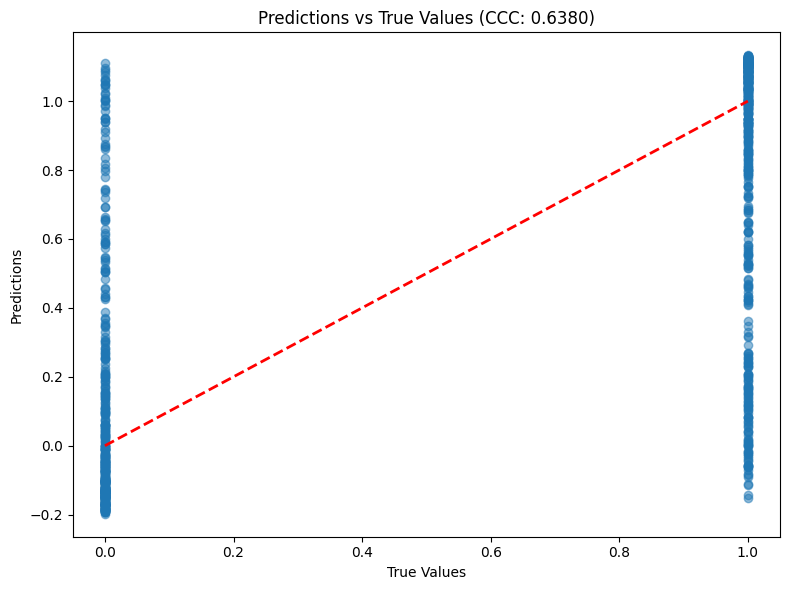

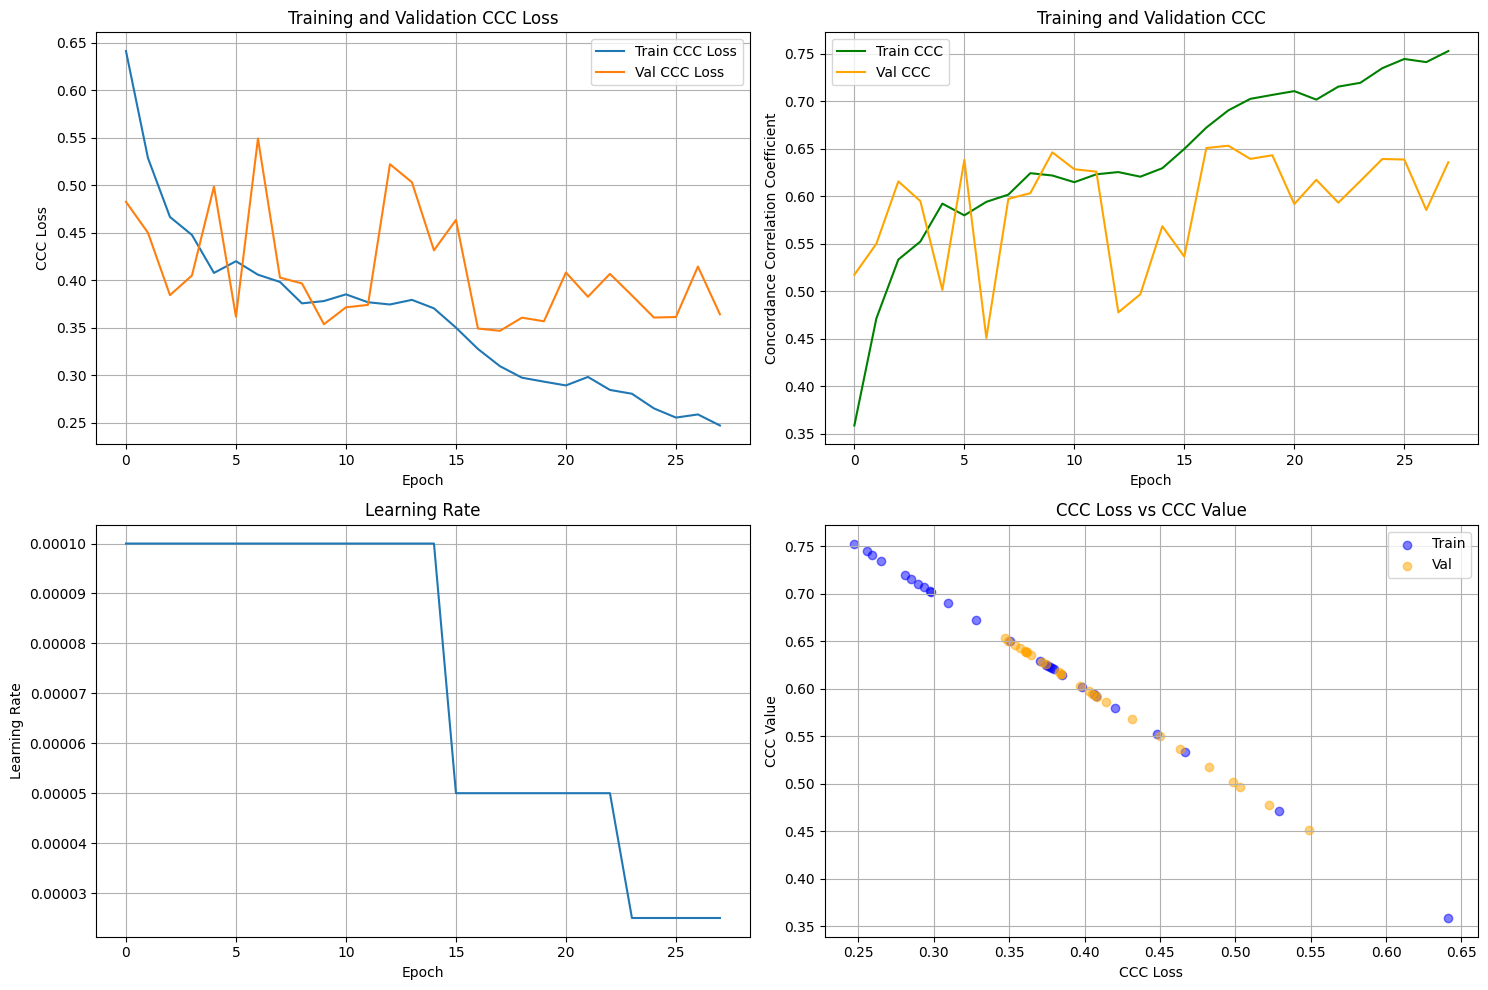


🎉 Training with CCC Loss completed!
📊 Final Test CCC: 0.6380


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from collections import Counter
from torch.utils.data import Dataset, DataLoader

# Required classes from previous implementations
class TemporalAttentionPooling(nn.Module):
    """Attention-based temporal pooling to get fixed-size representations"""
    def __init__(self, hidden_dim, num_heads=8, dropout=0.1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.head_dim = hidden_dim // num_heads
        
        # Multi-head attention for temporal pooling
        self.query = nn.Linear(hidden_dim, hidden_dim)
        self.key = nn.Linear(hidden_dim, hidden_dim)
        self.value = nn.Linear(hidden_dim, hidden_dim)
        self.attention_dropout = nn.Dropout(dropout)
        self.output_projection = nn.Linear(hidden_dim, hidden_dim)
        
        # Layer normalization
        self.layer_norm1 = nn.LayerNorm(hidden_dim)
        self.layer_norm2 = nn.LayerNorm(hidden_dim)
        
        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 4, hidden_dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        # x shape: [batch_size, seq_len, hidden_dim]
        batch_size, seq_len, hidden_dim = x.shape
        
        # Generate queries, keys, values
        Q = self.query(x)  # [batch_size, seq_len, hidden_dim]
        K = self.key(x)    # [batch_size, seq_len, hidden_dim]
        V = self.value(x)  # [batch_size, seq_len, hidden_dim]
        
        # Reshape for multi-head attention
        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        
        # Compute attention scores
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_weights = self.attention_dropout(attention_weights)
        
        # Apply attention to values
        attention_output = torch.matmul(attention_weights, V)
        attention_output = attention_output.transpose(1, 2).contiguous().view(
            batch_size, seq_len, hidden_dim
        )
        
        # Residual connection and layer norm
        attention_output = self.output_projection(attention_output)
        x = self.layer_norm1(x + attention_output)
        
        # Feed-forward with residual connection
        ffn_output = self.ffn(x)
        x = self.layer_norm2(x + ffn_output)
        
        # Global average pooling over time dimension
        pooled_output = x.mean(dim=1)  # [batch_size, hidden_dim]
        
        return pooled_output, attention_weights

class EmotionTransformer(nn.Module):
    """Transformer-based emotion classification model for HuBERT features"""
    
    def __init__(self, input_dim=768, hidden_dim=256, num_layers=4, num_heads=8, 
                 num_classes=2, dropout=0.2, max_seq_length=100):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_classes = num_classes
        
        # Input projection to match hidden dimension
        self.input_projection = nn.Linear(input_dim, hidden_dim)
        
        # Positional encoding
        self.positional_encoding = nn.Parameter(
            torch.zeros(1, max_seq_length, hidden_dim)
        )
        
        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, 
            num_layers=num_layers
        )
        
        # Temporal attention pooling
        self.temporal_pooling = TemporalAttentionPooling(
            hidden_dim=hidden_dim,
            num_heads=num_heads,
            dropout=dropout
        )
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 4, num_classes)
        )
        
        # Initialize weights
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.constant_(module.bias, 0)
            torch.nn.init.constant_(module.weight, 1.0)
        elif isinstance(module, nn.Parameter):
            torch.nn.init.normal_(module, mean=0.0, std=0.02)
    
    def forward(self, x):
        # x shape: [batch_size, 1, seq_len, input_dim]
        # Remove the extra dimension
        x = x.squeeze(1)  # [batch_size, seq_len, input_dim]
        
        # Project input to hidden dimension
        x = self.input_projection(x)  # [batch_size, seq_len, hidden_dim]
        
        # Add positional encoding
        seq_len = x.size(1)
        x = x + self.positional_encoding[:, :seq_len, :]
        
        # Apply transformer encoder
        x = self.transformer_encoder(x)  # [batch_size, seq_len, hidden_dim]
        
        # Apply temporal attention pooling
        pooled_output, attention_weights = self.temporal_pooling(x)
        
        # Classification
        logits = self.classifier(pooled_output)  # [batch_size, num_classes]
        
        return logits, attention_weights

class IEMOCAPHuBERTDataset(Dataset):
    def __init__(self, features, labels, max_length=None, pad_value=0.0):
        """
        Dataset for IEMOCAP HuBERT features
        
        Args:
            features: List of feature arrays [batch_size, seq_len, 768]
            labels: List of emotion labels
            max_length: Maximum sequence length (pad or truncate to this)
            pad_value: Value to use for padding
        """
        self.features = features
        self.labels = labels
        self.max_length = max_length
        self.pad_value = pad_value
        
        # Preprocess features to handle variable lengths
        self.processed_features = self._preprocess_features()
        
    def _preprocess_features(self):
        """Preprocess features to handle variable sequence lengths"""
        processed = []
        
        for feature in self.features:
            # Handle different feature formats
            if isinstance(feature, dict):
                # If features are stored as dictionaries with different representations
                if 'last_hidden_state' in feature:
                    feat_array = np.array(feature['last_hidden_state'])
                else:
                    # Use the first available feature
                    feat_array = np.array(list(feature.values())[0])
            else:
                feat_array = np.array(feature)
            
            # Ensure 3D shape [1, seq_len, 768] or [seq_len, 768]
            if feat_array.ndim == 1:
                # If it's already mean-pooled [768], expand to [1, 1, 768]
                feat_array = feat_array.reshape(1, 1, -1)
            elif feat_array.ndim == 2:
                # [seq_len, 768] -> [1, seq_len, 768]
                feat_array = feat_array[np.newaxis, :, :]
            
            # Pad or truncate to max_length
            if self.max_length is not None:
                seq_len = feat_array.shape[1]
                if seq_len > self.max_length:
                    # Truncate
                    feat_array = feat_array[:, :self.max_length, :]
                elif seq_len < self.max_length:
                    # Pad
                    pad_width = ((0, 0), (0, self.max_length - seq_len), (0, 0))
                    feat_array = np.pad(feat_array, pad_width, 
                                      mode='constant', 
                                      constant_values=self.pad_value)
            
            processed.append(feat_array)
        
        return processed
    
    def __len__(self):
        return len(self.processed_features)
    
    def __getitem__(self, idx):
        feature = torch.FloatTensor(self.processed_features[idx])
        label = self.labels[idx]
        return feature, label

def analyze_model_complexity(model):
    """Analyze model complexity"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\n🔢 Model Parameters:")
    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")
    print(f"  Non-trainable parameters: {total_params - trainable_params:,}")
    
    # Print model structure
    print(f"\n🏗️  Model Architecture:")
    print(model)

class HubertFeatureLoader:
    """Loader for HuBERT features that avoids the serialization issue"""
    
    def __init__(self, features_dir="./iemocap_hubert_features"):
        self.features_dir = features_dir
        self.features_path = os.path.join(features_dir, "features")
        self.metadata_path = os.path.join(features_dir, "metadata")
        
    def load_features_directly(self):
        """Load features directly from numpy files without serialization"""
        if not os.path.exists(self.features_path):
            raise FileNotFoundError(f"Features directory not found: {self.features_path}")
            
        feature_files = [f for f in os.listdir(self.features_path) if f.endswith('_hubert.npy')]
        
        if not feature_files:
            raise FileNotFoundError("No feature files found!")
        
        all_features = []
        all_emotions = []
        
        print(f"📁 Loading {len(feature_files)} feature files directly...")
        
        for feature_file in feature_files:
            try:
                # Load features
                features_data = np.load(os.path.join(self.features_path, feature_file), 
                                      allow_pickle=True).item()
                
                # Load corresponding metadata
                metadata_file = feature_file.replace('.npy', '_metadata.json')
                metadata_path = os.path.join(self.metadata_path, metadata_file)
                
                if os.path.exists(metadata_path):
                    with open(metadata_path, 'r') as f:
                        metadata = json.load(f)
                else:
                    print(f"⚠️ Metadata file not found: {metadata_file}")
                    continue
                
                all_features.extend(features_data['hubert_features'])
                all_emotions.extend([m['emotion'] for m in metadata])
                
            except Exception as e:
                print(f"❌ Error loading {feature_file}: {e}")
                continue
        
        print(f"✅ Loaded {len(all_features)} feature vectors")
        return all_features, all_emotions
    
    def create_emotion_mapping(self, emotions):
        """Create emotion to label mapping"""
        emotion_counts = Counter(emotions)
        print("🎭 Emotion Distribution:")
        for emotion, count in emotion_counts.most_common():
            print(f"   {emotion}: {count}")
        
        # Create mapping
        emotion_mapping = {emotion: idx for idx, emotion in enumerate(sorted(set(emotions)))}
        
        print(f"\n🎯 Using {len(emotion_mapping)} emotions: {list(emotion_mapping.keys())}")
        
        return emotion_mapping
    
    def prepare_datasets_directly(self, test_size=0.15, val_size=0.15, max_seq_length=100, 
                                random_state=42):
        """Prepare datasets directly from features without saving/loading"""
        # Load features directly
        features, emotions = self.load_features_directly()
        
        if not features:
            raise ValueError("No features loaded!")
        
        # Create emotion mapping
        emotion_mapping = self.create_emotion_mapping(emotions)
        
        # Convert emotions to labels
        labels = [emotion_mapping[emotion] for emotion in emotions]
        
        # First split: separate test set
        X_temp, X_test, y_temp, y_test = train_test_split(
            features, labels,
            test_size=test_size,
            random_state=random_state,
            stratify=labels
        )
        
        # Second split: separate validation set from temporary training set
        val_size_adj = val_size / (1 - test_size)  # Adjust val_size for the remaining data
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp,
            test_size=val_size_adj,
            random_state=random_state,
            stratify=y_temp
        )
        
        print(f"📈 Dataset Split:")
        print(f"   Train: {len(X_train)} samples")
        print(f"   Val: {len(X_val)} samples")
        print(f"   Test: {len(X_test)} samples")
        
        # Create datasets
        train_dataset = IEMOCAPHuBERTDataset(X_train, y_train, max_length=max_seq_length)
        val_dataset = IEMOCAPHuBERTDataset(X_val, y_val, max_length=max_seq_length)
        test_dataset = IEMOCAPHuBERTDataset(X_test, y_test, max_length=max_seq_length)
        
        return {
            'train': train_dataset,
            'val': val_dataset,
            'test': test_dataset,
            'emotion_mapping': emotion_mapping
        }

# CCC Loss Implementation
class CCCLoss(nn.Module):
    """Concordance Correlation Coefficient Loss for continuous emotion signals"""
    def __init__(self, reduction='mean'):
        super(CCCLoss, self).__init__()
        self.reduction = reduction

    def forward(self, predictions, targets):
        # Calculate means
        pred_mean = torch.mean(predictions)
        target_mean = torch.mean(targets)
        
        # Calculate variances
        pred_var = torch.var(predictions)
        target_var = torch.var(targets)
        
        # Calculate covariance
        covariance = torch.mean((predictions - pred_mean) * (targets - target_mean))
        
        # Calculate CCC
        ccc_numerator = 2.0 * covariance
        ccc_denominator = pred_var + target_var + (pred_mean - target_mean) ** 2
        ccc = ccc_numerator / ccc_denominator
        
        # CCC loss (1 - CCC since we want to maximize CCC)
        ccc_loss = 1.0 - ccc
        
        return ccc_loss

class EmotionTrainerWithCCCLoss:
    """Trainer class with CCC Loss for continuous emotion regression"""
    
    def __init__(self, model, train_loader, val_loader, test_loader, 
                 device='cuda', learning_rate=1e-4, weight_decay=1e-4):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # CCC Loss for regression
        self.criterion = CCCLoss()
        
        # Optimizer
        self.optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=learning_rate, 
            weight_decay=weight_decay
        )
        
        # Learning rate scheduler
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', patience=5, factor=0.5
        )
        
        # Training history
        self.history = {
            'train_loss': [], 'val_loss': [],
            'train_ccc': [], 'val_ccc': [],
            'learning_rates': []
        }

    def train_epoch(self):
        """Train for one epoch with CCC Loss"""
        self.model.train()
        total_loss = 0
        total_ccc = 0
        total_batches = 0
        
        for batch_idx, (features, labels) in enumerate(self.train_loader):
            features = features.to(self.device)
            labels = labels.to(self.device).float()
            
            # Forward pass
            self.optimizer.zero_grad()
            predictions, _ = self.model(features)
            loss = self.criterion(predictions.squeeze(), labels)
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            
            # Statistics
            total_loss += loss.item()
            ccc_value = 1.0 - loss.item()  # CCC = 1 - CCC Loss
            total_ccc += ccc_value
            total_batches += 1
            
            if batch_idx % 50 == 0:
                print(f'  Batch {batch_idx}/{len(self.train_loader)}, '
                      f'CCC Loss: {loss.item():.4f}, CCC: {ccc_value:.4f}')
        
        epoch_loss = total_loss / total_batches
        epoch_ccc = total_ccc / total_batches
        
        return epoch_loss, epoch_ccc

    def validate(self, loader):
        """Validate on given data loader"""
        self.model.eval()
        total_loss = 0
        total_ccc = 0
        total_batches = 0
        all_predictions = []
        all_targets = []
        
        with torch.no_grad():
            for features, targets in loader:
                features = features.to(self.device)
                targets = targets.to(self.device).float()
                
                predictions, _ = self.model(features)
                loss = self.criterion(predictions.squeeze(), targets)
                
                total_loss += loss.item()
                ccc_value = 1.0 - loss.item()
                total_ccc += ccc_value
                total_batches += 1
                
                all_predictions.extend(predictions.squeeze().cpu().numpy())
                all_targets.extend(targets.cpu().numpy())
        
        epoch_loss = total_loss / total_batches
        epoch_ccc = total_ccc / total_batches
        
        return epoch_loss, epoch_ccc, all_predictions, all_targets

    def train(self, num_epochs=50, early_stopping_patience=10):
        """Full training loop with CCC Loss"""
        print("🚀 Starting training with CCC Loss...")
        
        best_val_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(num_epochs):
            start_time = time.time()
            
            # Train with CCC Loss
            train_loss, train_ccc = self.train_epoch()
            
            # Validate
            val_loss, val_ccc, _, _ = self.validate(self.val_loader)
            
            # Update learning rate
            self.scheduler.step(val_loss)
            current_lr = self.optimizer.param_groups[0]['lr']
            
            # Record history
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['train_ccc'].append(train_ccc)
            self.history['val_ccc'].append(val_ccc)
            self.history['learning_rates'].append(current_lr)
            
            epoch_time = time.time() - start_time
            
            print(f'Epoch {epoch+1}/{num_epochs} - {epoch_time:.1f}s')
            print(f'  Train CCC Loss: {train_loss:.4f}, Train CCC: {train_ccc:.4f}')
            print(f'  Val CCC Loss: {val_loss:.4f}, Val CCC: {val_ccc:.4f}')
            print(f'  LR: {current_lr:.2e}')
            
            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # Save best model
                torch.save(self.model.state_dict(), 'best_emotion_model_ccc.pth')
                print('  💾 New best model saved!')
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f'  🛑 Early stopping after {epoch+1} epochs')
                    break
            
            print('-' * 60)
        
        # Load best model
        self.model.load_state_dict(torch.load('best_emotion_model_ccc.pth'))
        print('✅ Training with CCC Loss completed!')

    def evaluate(self):
        """Comprehensive evaluation on test set"""
        print("\n🧪 Evaluating on test set with CCC Loss...")
        
        test_loss, test_ccc, predictions, targets = self.validate(self.test_loader)
        
        # Calculate additional metrics
        predictions = np.array(predictions)
        targets = np.array(targets)
        
        # Pearson correlation
        pearson_corr = np.corrcoef(predictions, targets)[0, 1]
        
        # Mean Absolute Error
        mae = np.mean(np.abs(predictions - targets))
        
        # Root Mean Square Error
        rmse = np.sqrt(np.mean((predictions - targets) ** 2))
        
        print(f"\n📊 Test Results (CCC Loss):")
        print(f"  CCC Loss: {test_loss:.4f}")
        print(f"  Concordance Correlation Coefficient: {test_ccc:.4f}")
        print(f"  Pearson Correlation: {pearson_corr:.4f}")
        print(f"  Mean Absolute Error: {mae:.4f}")
        print(f"  Root Mean Square Error: {rmse:.4f}")
        
        # Scatter plot
        plt.figure(figsize=(8, 6))
        plt.scatter(targets, predictions, alpha=0.5)
        plt.plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'r--', lw=2)
        plt.xlabel('True Values')
        plt.ylabel('Predictions')
        plt.title(f'Predictions vs True Values (CCC: {test_ccc:.4f})')
        plt.tight_layout()
        plt.show()
        
        return test_ccc, test_loss

    def plot_training_history(self):
        """Plot training history for CCC Loss"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # CCC Loss
        ax1.plot(self.history['train_loss'], label='Train CCC Loss')
        ax1.plot(self.history['val_loss'], label='Val CCC Loss')
        ax1.set_title('Training and Validation CCC Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('CCC Loss')
        ax1.legend()
        ax1.grid(True)
        
        # CCC Value
        ax2.plot(self.history['train_ccc'], label='Train CCC', c='green')
        ax2.plot(self.history['val_ccc'], label='Val CCC', c='orange')
        ax2.set_title('Training and Validation CCC')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Concordance Correlation Coefficient')
        ax2.legend()
        ax2.grid(True)
        
        # Learning rate
        ax3.plot(self.history['learning_rates'])
        ax3.set_title('Learning Rate')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Learning Rate')
        ax3.grid(True)
        
        # Loss vs CCC
        ax4.scatter(self.history['train_loss'], self.history['train_ccc'], 
                   alpha=0.5, label='Train', c='blue')
        ax4.scatter(self.history['val_loss'], self.history['val_ccc'], 
                   alpha=0.5, label='Val', c='orange')
        ax4.set_xlabel('CCC Loss')
        ax4.set_ylabel('CCC Value')
        ax4.set_title('CCC Loss vs CCC Value')
        ax4.legend()
        ax4.grid(True)
        
        plt.tight_layout()
        plt.show()

def main_training_with_ccc_loss():
    """Main training function with CCC Loss"""
    print("🎵 Training Emotion Regression Model with CCC LOSS")
    print("=" * 60)
    
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"📱 Using device: {device}")
    
    # Load data directly
    print("📦 Loading HuBERT features directly...")
    loader = HubertFeatureLoader()
    datasets = loader.prepare_datasets_directly(
        test_size=0.15,
        val_size=0.15, 
        max_seq_length=100,
        random_state=42
    )
    
    # Create data loaders
    data_loaders = {
        'train': DataLoader(datasets['train'], batch_size=32, shuffle=True, num_workers=0),
        'val': DataLoader(datasets['val'], batch_size=32, shuffle=False, num_workers=0),
        'test': DataLoader(datasets['test'], batch_size=32, shuffle=False, num_workers=0)
    }
    
    # Model configuration for regression (single output)
    model = EmotionTransformer(
        input_dim=768,
        hidden_dim=256,
        num_layers=4,
        num_heads=8,
        num_classes=1,  # Single output for regression
        dropout=0.2,
        max_seq_length=100
    )
    
    # Analyze model
    analyze_model_complexity(model)
    
    # Create trainer with CCC Loss
    trainer = EmotionTrainerWithCCCLoss(
        model=model,
        train_loader=data_loaders['train'],
        val_loader=data_loaders['val'],
        test_loader=data_loaders['test'],
        device=device,
        learning_rate=1e-4,
        weight_decay=1e-4
    )
    
    # Train model with CCC Loss
    trainer.train(num_epochs=50, early_stopping_patience=10)
    
    # Evaluate model
    test_ccc, test_loss = trainer.evaluate()
    
    # Plot training history
    trainer.plot_training_history()
    
    # Save training results
    results = {
        'test_ccc': test_ccc,
        'test_loss': test_loss,
        'loss_function': 'Concordance Correlation Coefficient Loss',
        'model_parameters': sum(p.numel() for p in model.parameters()),
        'training_history': {
            'train_loss': trainer.history['train_loss'],
            'val_loss': trainer.history['val_loss'],
            'train_ccc': trainer.history['train_ccc'],
            'val_ccc': trainer.history['val_ccc']
        }
    }
    
    with open('training_results_ccc_loss.json', 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"\n🎉 Training with CCC Loss completed!")
    print(f"📊 Final Test CCC: {test_ccc:.4f}")
    
    return trainer

# Run CCC loss training
if __name__ == "__main__":
    trainer_ccc = main_training_with_ccc_loss()

🎵 Training Emotion Classification with IMPROVED ARCFACE
📱 Using device: cpu
📦 Loading HuBERT features directly...
📁 Loading 13 feature files directly...
✅ Loaded 6059 feature vectors
🎭 Emotion Distribution:
   neutral: 3173
   emotional: 2886

🎯 Using 2 emotions: ['emotional', 'neutral']
📈 Dataset Split:
   Train: 4241 samples
   Val: 909 samples
   Test: 909 samples
🎯 Number of classes: 2
📦 Emotions: ['emotional', 'neutral']

🔢 Model Parameters:
  Total parameters: 1,824,386
  Trainable parameters: 1,824,386
  Non-trainable parameters: 0

🏗️  Model Architecture:
EmotionTransformerWithArcFace(
  (input_projection): Linear(in_features=768, out_features=256, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512,

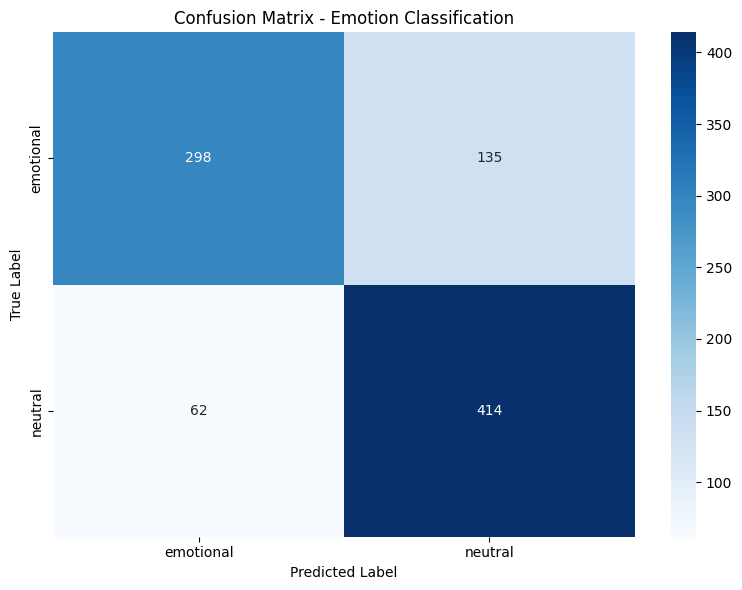

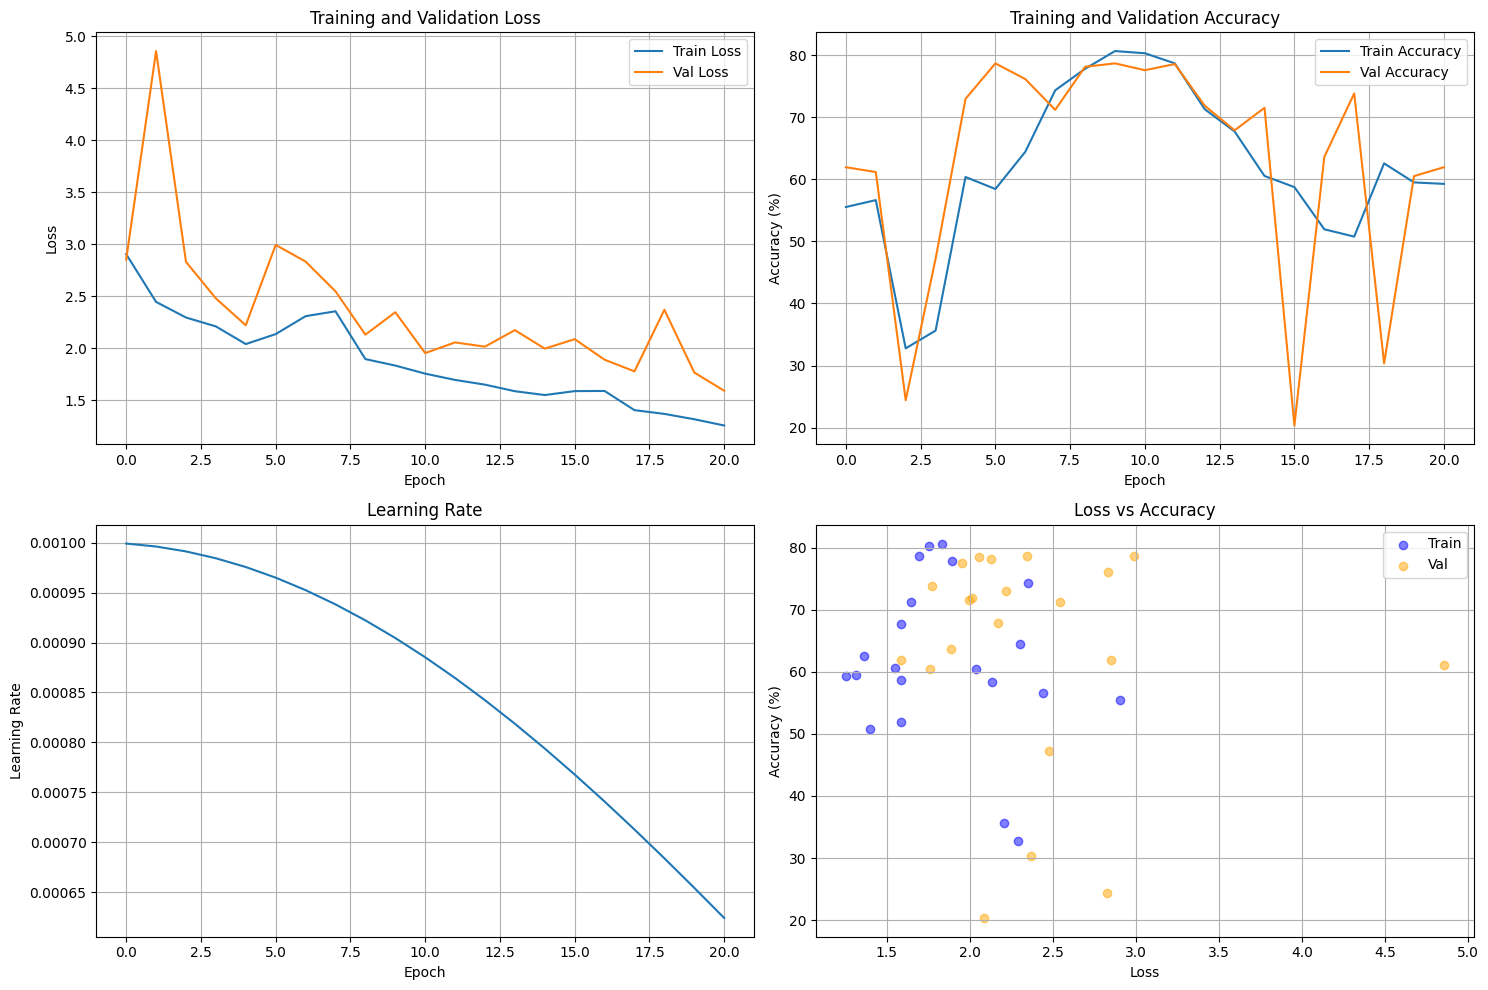


🎉 Training completed!
📊 Final Test Accuracy: 78.33%


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class ArcFaceLoss(nn.Module):
    """Additive Angular Margin Loss with better stability for 2-class problems"""
    def __init__(self, num_classes, embedding_size, margin=0.3, scale=16, reduction='mean'):
        super(ArcFaceLoss, self).__init__()
        self.num_classes = num_classes
        self.embedding_size = embedding_size
        self.margin = margin  # Reduced margin for 2-class problem
        self.scale = scale    # Reduced scale for stability
        self.reduction = reduction
        
        # Weight matrix for classification
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, embedding_size))
        nn.init.xavier_uniform_(self.weight)
        
        # Pre-calculate cosine and sine of margin
        self.cos_m = math.cos(margin)
        self.sin_m = math.sin(margin)
        self.th = math.cos(math.pi - margin)
        self.mm = math.sin(math.pi - margin) * margin

    def forward(self, embeddings, labels):
        # Normalize embeddings and weights
        normalized_embeddings = F.normalize(embeddings, p=2, dim=1)
        normalized_weight = F.normalize(self.weight, p=2, dim=1)
        
        # Cosine similarity
        cosine = F.linear(normalized_embeddings, normalized_weight)
        
        # Ensure numerical stability
        cosine = cosine.clamp(-1 + 1e-7, 1 - 1e-7)
        
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        
        # cos(θ + m)
        phi = cosine * self.cos_m - sine * self.sin_m
        
        # Use torch.where for better numerical stability
        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, labels.view(-1, 1).long(), 1)
        
        # Apply margin to correct classes
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.scale
        
        # Calculate cross entropy loss
        loss = F.cross_entropy(output, labels, reduction=self.reduction)
        
        return loss

class EmotionTransformerWithArcFace(nn.Module):
    """Transformer model with improved architecture for ArcFace"""
    
    def __init__(self, input_dim=768, hidden_dim=256, num_layers=3, num_heads=8, 
                 num_classes=2, dropout=0.1, max_seq_length=100, embedding_size=128):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.embedding_size = embedding_size
        
        # Input projection
        self.input_projection = nn.Linear(input_dim, hidden_dim)
        
        # Positional encoding
        self.positional_encoding = nn.Parameter(
            torch.zeros(1, max_seq_length, hidden_dim)
        )
        
        # Simplified transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 2,  # Reduced
            dropout=dropout,
            activation='relu',  # Changed to ReLU for stability
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, 
            num_layers=num_layers
        )
        
        # Simplified temporal pooling (global average pooling)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        # Embedding projection with batch norm
        self.embedding_layer = nn.Sequential(
            nn.Linear(hidden_dim, embedding_size),
            nn.BatchNorm1d(embedding_size),
            nn.ReLU(),  # Changed to ReLU
            nn.Dropout(dropout)
        )
        
        # Classification head
        self.classifier = nn.Linear(embedding_size, num_classes)
        
        # Initialize weights
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.constant_(module.bias, 0)
            torch.nn.init.constant_(module.weight, 1.0)
        elif isinstance(module, nn.BatchNorm1d):
            torch.nn.init.constant_(module.weight, 1.0)
            torch.nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.Parameter):
            torch.nn.init.normal_(module, mean=0.0, std=0.02)
    
    def forward(self, x, return_embeddings=False):
        # x shape: [batch_size, 1, seq_len, input_dim]
        x = x.squeeze(1)  # [batch_size, seq_len, input_dim]
        
        # Project input
        x = self.input_projection(x)
        
        # Add positional encoding
        seq_len = x.size(1)
        x = x + self.positional_encoding[:, :seq_len, :]
        
        # Apply transformer encoder
        x = self.transformer_encoder(x)
        
        # Global average pooling
        x = x.transpose(1, 2)  # [batch_size, hidden_dim, seq_len]
        x = self.global_pool(x).squeeze(-1)  # [batch_size, hidden_dim]
        
        # Get embeddings
        embeddings = self.embedding_layer(x)
        
        if return_embeddings:
            return embeddings, None
        
        # Classification
        logits = self.classifier(embeddings)
        
        return logits, None, embeddings

class ImprovedEmotionTrainerWithArcFace:
    """Improved trainer with better optimization and monitoring"""
    
    def __init__(self, model, train_loader, val_loader, test_loader, 
                 device='cuda', learning_rate=1e-3, weight_decay=1e-4,  # Higher LR
                 arcface_margin=0.3, arcface_scale=16):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # ArcFace Loss with gentler parameters
        self.criterion = ArcFaceLoss(
            num_classes=model.num_classes,
            embedding_size=model.embedding_size,
            margin=arcface_margin,
            scale=arcface_scale
        ).to(device)
        
        # Separate optimizers for model and ArcFace weights
        self.optimizer_model = torch.optim.AdamW(
            model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        )
        
        self.optimizer_arcface = torch.optim.AdamW(
            self.criterion.parameters(),
            lr=learning_rate * 0.1,  # Lower LR for ArcFace weights
            weight_decay=weight_decay
        )
        
        # Cosine annealing scheduler
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer_model, T_max=50
        )
        
        # Training history
        self.history = {
            'train_loss': [], 'val_loss': [],
            'train_acc': [], 'val_acc': [],
            'learning_rates': []
        }

    def train_epoch(self):
        """Train for one epoch with improved stability"""
        self.model.train()
        self.criterion.train()
        
        total_loss = 0
        correct = 0
        total = 0
        
        for batch_idx, (features, labels) in enumerate(self.train_loader):
            features = features.to(self.device)
            labels = labels.to(self.device)
            
            # Forward pass
            self.optimizer_model.zero_grad()
            self.optimizer_arcface.zero_grad()
            
            embeddings, _ = self.model(features, return_embeddings=True)
            loss = self.criterion(embeddings, labels)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            torch.nn.utils.clip_grad_norm_(self.criterion.parameters(), max_norm=1.0)
            
            self.optimizer_model.step()
            self.optimizer_arcface.step()
            
            # Calculate accuracy
            with torch.no_grad():
                logits, _, _ = self.model(features)
                _, predicted = torch.max(logits, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
            total_loss += loss.item()
            
            if batch_idx % 50 == 0:
                current_acc = 100. * correct / total
                print(f'  Batch {batch_idx}/{len(self.train_loader)}, '
                      f'Loss: {loss.item():.4f}, Acc: {current_acc:.2f}%')
        
        epoch_loss = total_loss / len(self.train_loader)
        epoch_acc = 100. * correct / total
        
        return epoch_loss, epoch_acc

    def validate(self, loader):
        """Validate on given data loader"""
        self.model.eval()
        self.criterion.eval()
        
        total_loss = 0
        correct = 0
        total = 0
        all_predictions = []
        all_labels = []
        
        with torch.no_grad():
            for features, labels in loader:
                features = features.to(self.device)
                labels = labels.to(self.device)
                
                # Get embeddings for loss
                embeddings, _ = self.model(features, return_embeddings=True)
                loss = self.criterion(embeddings, labels)
                
                # Get predictions
                logits, _, _ = self.model(features)
                _, predicted = torch.max(logits, 1)
                
                total_loss += loss.item()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        epoch_loss = total_loss / len(loader)
        epoch_acc = 100. * correct / total
        
        return epoch_loss, epoch_acc, all_predictions, all_labels

    def train(self, num_epochs=50, early_stopping_patience=15):
        """Full training loop with improved monitoring"""
        print("🚀 Starting training with Improved ArcFace...")
        print(f"📊 ArcFace parameters: margin={self.criterion.margin}, scale={self.criterion.scale}")
        
        best_val_acc = 0.0
        patience_counter = 0
        
        for epoch in range(num_epochs):
            start_time = time.time()
            
            # Train
            train_loss, train_acc = self.train_epoch()
            
            # Validate
            val_loss, val_acc, _, _ = self.validate(self.val_loader)
            
            # Update learning rate
            self.scheduler.step()
            current_lr = self.optimizer_model.param_groups[0]['lr']
            
            # Record history
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_acc'].append(val_acc)
            self.history['learning_rates'].append(current_lr)
            
            epoch_time = time.time() - start_time
            
            print(f'Epoch {epoch+1}/{num_epochs} - {epoch_time:.1f}s')
            print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
            print(f'  LR: {current_lr:.2e}')
            
            # Early stopping based on validation accuracy
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                torch.save({
                    'model_state_dict': self.model.state_dict(),
                    'arcface_state_dict': self.criterion.state_dict(),
                    'optimizer_model_state_dict': self.optimizer_model.state_dict(),
                    'optimizer_arcface_state_dict': self.optimizer_arcface.state_dict(),
                    'epoch': epoch,
                    'best_val_acc': best_val_acc
                }, 'best_emotion_model_arcface_improved.pth')
                print(f'  💾 New best model saved! Val Acc: {val_acc:.2f}%')
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f'  🛑 Early stopping after {epoch+1} epochs')
                    break
            
            print('-' * 60)
        
        # Load best model
        checkpoint = torch.load('best_emotion_model_arcface_improved.pth')
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.criterion.load_state_dict(checkpoint['arcface_state_dict'])
        print(f'✅ Training completed! Best Val Acc: {checkpoint["best_val_acc"]:.2f}%')

    def evaluate(self, emotion_mapping):
        """Comprehensive evaluation on test set"""
        print("\n🧪 Evaluating on test set...")
        
        test_loss, test_acc, predictions, true_labels = self.validate(self.test_loader)
        
        # Convert numeric labels to emotion names
        id_to_emotion = {v: k for k, v in emotion_mapping.items()}
        emotion_names = [id_to_emotion[i] for i in sorted(id_to_emotion.keys())]
        
        # Classification report
        print(f"\n📊 Test Results:")
        print(f"  Loss: {test_loss:.4f}")
        print(f"  Accuracy: {test_acc:.2f}%")
        
        print(f"\n📈 Classification Report:")
        print(classification_report(true_labels, predictions, 
                                  target_names=emotion_names, digits=4))
        
        # Confusion matrix
        cm = confusion_matrix(true_labels, predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=emotion_names, yticklabels=emotion_names)
        plt.title('Confusion Matrix - Emotion Classification')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
        
        return test_acc, test_loss

    def plot_training_history(self):
        """Plot training history"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Loss
        ax1.plot(self.history['train_loss'], label='Train Loss')
        ax1.plot(self.history['val_loss'], label='Val Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Accuracy
        ax2.plot(self.history['train_acc'], label='Train Accuracy')
        ax2.plot(self.history['val_acc'], label='Val Accuracy')
        ax2.set_title('Training and Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid(True)
        
        # Learning rate
        ax3.plot(self.history['learning_rates'])
        ax3.set_title('Learning Rate')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Learning Rate')
        ax3.grid(True)
        
        # Loss vs Accuracy
        ax4.scatter(self.history['train_loss'], self.history['train_acc'], 
                   alpha=0.5, label='Train', c='blue')
        ax4.scatter(self.history['val_loss'], self.history['val_acc'], 
                   alpha=0.5, label='Val', c='orange')
        ax4.set_xlabel('Loss')
        ax4.set_ylabel('Accuracy (%)')
        ax4.set_title('Loss vs Accuracy')
        ax4.legend()
        ax4.grid(True)
        
        plt.tight_layout()
        plt.show()

def main_training_with_improved_arcface():
    """Main training function with improved ArcFace"""
    print("🎵 Training Emotion Classification with IMPROVED ARCFACE")
    print("=" * 60)
    
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"📱 Using device: {device}")
    
    # Load data directly
    print("📦 Loading HuBERT features directly...")
    loader = HubertFeatureLoader()
    datasets = loader.prepare_datasets_directly(
        test_size=0.15,
        val_size=0.15, 
        max_seq_length=50,  # Reduced sequence length
        random_state=42
    )
    
    # Create data loaders
    data_loaders = {
        'train': DataLoader(datasets['train'], batch_size=64, shuffle=True, num_workers=0),  # Increased batch size
        'val': DataLoader(datasets['val'], batch_size=64, shuffle=False, num_workers=0),
        'test': DataLoader(datasets['test'], batch_size=64, shuffle=False, num_workers=0)
    }
    
    # Model configuration
    num_classes = len(datasets['emotion_mapping'])
    print(f"🎯 Number of classes: {num_classes}")
    print(f"📦 Emotions: {list(datasets['emotion_mapping'].keys())}")
    
    # Create improved model
    model = EmotionTransformerWithArcFace(
        input_dim=768,
        hidden_dim=256,
        num_layers=3,  # Reduced layers
        num_heads=8,
        num_classes=num_classes,
        dropout=0.1,   # Reduced dropout
        max_seq_length=50,
        embedding_size=128  # Smaller embedding size
    )
    
    # Analyze model
    analyze_model_complexity(model)
    
    # Create improved trainer
    trainer = ImprovedEmotionTrainerWithArcFace(
        model=model,
        train_loader=data_loaders['train'],
        val_loader=data_loaders['val'],
        test_loader=data_loaders['test'],
        device=device,
        learning_rate=1e-3,  # Higher learning rate
        weight_decay=1e-4,
        arcface_margin=0.3,  # Gentler margin
        arcface_scale=16     # Lower scale
    )
    
    # Train model
    trainer.train(num_epochs=50, early_stopping_patience=15)
    
    # Evaluate model
    test_acc, test_loss = trainer.evaluate(datasets['emotion_mapping'])
    
    # Plot training history
    trainer.plot_training_history()
    
    # Save training results
    results = {
        'test_accuracy': test_acc,
        'test_loss': test_loss,
        'num_classes': num_classes,
        'emotions': list(datasets['emotion_mapping'].keys()),
        'loss_function': 'Improved ArcFace Loss',
        'arcface_margin': trainer.criterion.margin,
        'arcface_scale': trainer.criterion.scale,
        'model_parameters': sum(p.numel() for p in model.parameters()),
        'training_history': {
            'train_loss': trainer.history['train_loss'],
            'val_loss': trainer.history['val_loss'],
            'train_acc': trainer.history['train_acc'],
            'val_acc': trainer.history['val_acc']
        }
    }
    
    with open('training_results_arcface_improved.json', 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"\n🎉 Training completed!")
    print(f"📊 Final Test Accuracy: {test_acc:.2f}%")
    
    return trainer

# Run improved ArcFace training
if __name__ == "__main__":
    trainer_improved = main_training_with_improved_arcface()

🎵 Training Emotion Classification Model with FOCAL LOSS
📱 Using device: cpu
📦 Loading HuBERT features directly...
📁 Loading 13 feature files directly...
✅ Loaded 6059 feature vectors
🎭 Emotion Distribution:
   neutral: 3173
   emotional: 2886

🎯 Using 2 emotions: ['emotional', 'neutral']
📈 Dataset Split:
   Train: 4241 samples
   Val: 909 samples
   Test: 909 samples
🎯 Number of classes: 2
📦 Emotions: ['emotional', 'neutral']

🔢 Model Parameters:
  Total parameters: 4,212,546
  Trainable parameters: 4,212,546
  Non-trainable parameters: 0

🏗️  Model Architecture:
EmotionTransformer(
  (input_projection): Linear(in_features=768, out_features=256, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=1024, bias=True

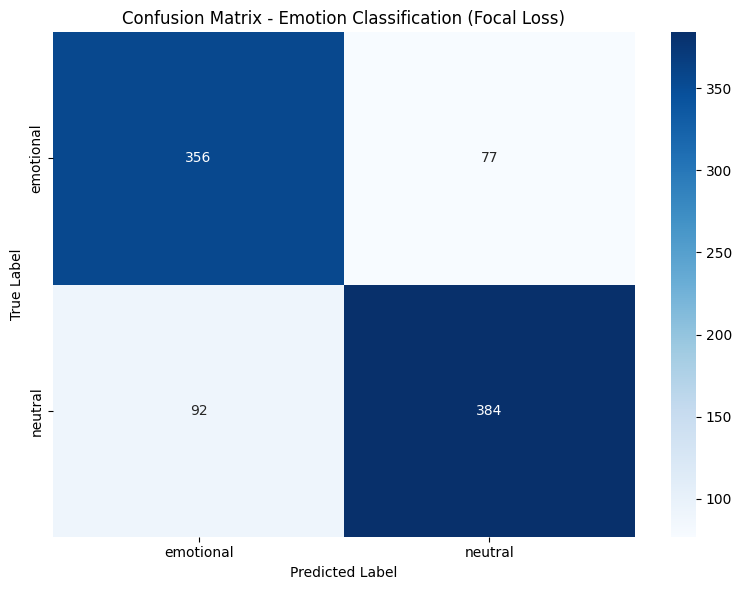

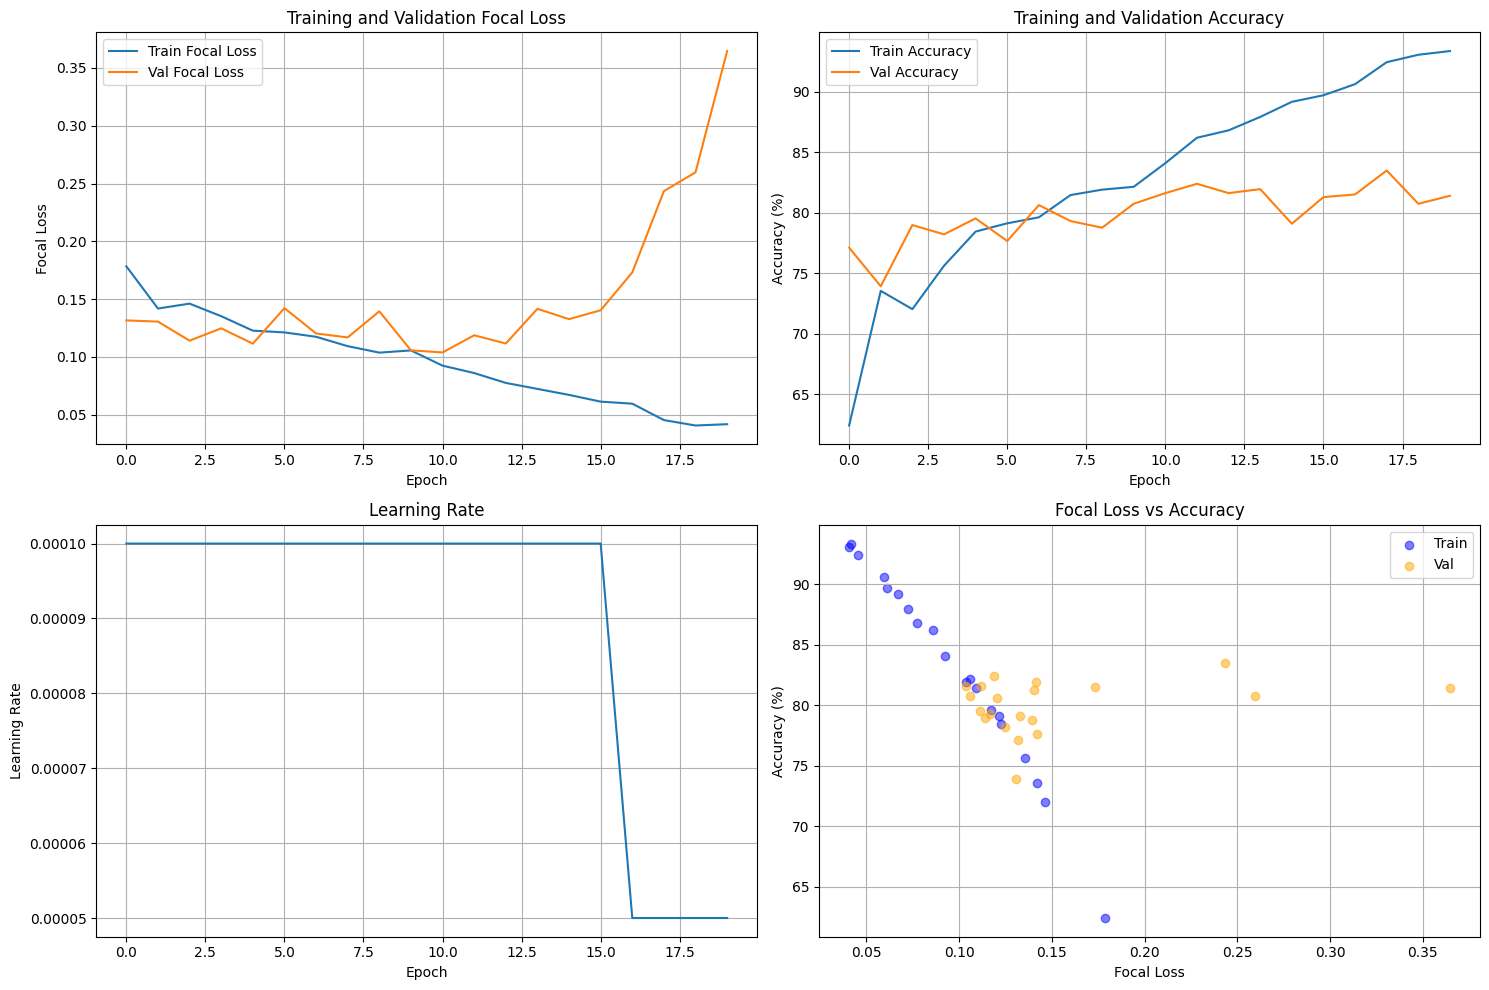


🎉 Training with Focal Loss completed!
📊 Final Test Accuracy: 81.41%


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from collections import Counter
from torch.utils.data import Dataset, DataLoader

# Add missing imports and classes
class TemporalAttentionPooling(nn.Module):
    """Attention-based temporal pooling to get fixed-size representations"""
    def __init__(self, hidden_dim, num_heads=8, dropout=0.1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.head_dim = hidden_dim // num_heads
        
        # Multi-head attention for temporal pooling
        self.query = nn.Linear(hidden_dim, hidden_dim)
        self.key = nn.Linear(hidden_dim, hidden_dim)
        self.value = nn.Linear(hidden_dim, hidden_dim)
        self.attention_dropout = nn.Dropout(dropout)
        self.output_projection = nn.Linear(hidden_dim, hidden_dim)
        
        # Layer normalization
        self.layer_norm1 = nn.LayerNorm(hidden_dim)
        self.layer_norm2 = nn.LayerNorm(hidden_dim)
        
        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 4, hidden_dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        # x shape: [batch_size, seq_len, hidden_dim]
        batch_size, seq_len, hidden_dim = x.shape
        
        # Generate queries, keys, values
        Q = self.query(x)  # [batch_size, seq_len, hidden_dim]
        K = self.key(x)    # [batch_size, seq_len, hidden_dim]
        V = self.value(x)  # [batch_size, seq_len, hidden_dim]
        
        # Reshape for multi-head attention
        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        
        # Compute attention scores
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_weights = self.attention_dropout(attention_weights)
        
        # Apply attention to values
        attention_output = torch.matmul(attention_weights, V)
        attention_output = attention_output.transpose(1, 2).contiguous().view(
            batch_size, seq_len, hidden_dim
        )
        
        # Residual connection and layer norm
        attention_output = self.output_projection(attention_output)
        x = self.layer_norm1(x + attention_output)
        
        # Feed-forward with residual connection
        ffn_output = self.ffn(x)
        x = self.layer_norm2(x + ffn_output)
        
        # Global average pooling over time dimension
        pooled_output = x.mean(dim=1)  # [batch_size, hidden_dim]
        
        return pooled_output, attention_weights

class EmotionTransformer(nn.Module):
    """Transformer-based emotion classification model for HuBERT features"""
    
    def __init__(self, input_dim=768, hidden_dim=256, num_layers=4, num_heads=8, 
                 num_classes=2, dropout=0.2, max_seq_length=100):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_classes = num_classes
        
        # Input projection to match hidden dimension
        self.input_projection = nn.Linear(input_dim, hidden_dim)
        
        # Positional encoding
        self.positional_encoding = nn.Parameter(
            torch.zeros(1, max_seq_length, hidden_dim)
        )
        
        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, 
            num_layers=num_layers
        )
        
        # Temporal attention pooling
        self.temporal_pooling = TemporalAttentionPooling(
            hidden_dim=hidden_dim,
            num_heads=num_heads,
            dropout=dropout
        )
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 4, num_classes)
        )
        
        # Initialize weights
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.constant_(module.bias, 0)
            torch.nn.init.constant_(module.weight, 1.0)
        elif isinstance(module, nn.Parameter):
            torch.nn.init.normal_(module, mean=0.0, std=0.02)
    
    def forward(self, x):
        # x shape: [batch_size, 1, seq_len, input_dim]
        # Remove the extra dimension
        x = x.squeeze(1)  # [batch_size, seq_len, input_dim]
        
        # Project input to hidden dimension
        x = self.input_projection(x)  # [batch_size, seq_len, hidden_dim]
        
        # Add positional encoding
        seq_len = x.size(1)
        x = x + self.positional_encoding[:, :seq_len, :]
        
        # Apply transformer encoder
        x = self.transformer_encoder(x)  # [batch_size, seq_len, hidden_dim]
        
        # Apply temporal attention pooling
        pooled_output, attention_weights = self.temporal_pooling(x)
        
        # Classification
        logits = self.classifier(pooled_output)  # [batch_size, num_classes]
        
        return logits, attention_weights

class IEMOCAPHuBERTDataset(Dataset):
    def __init__(self, features, labels, max_length=None, pad_value=0.0):
        """
        Dataset for IEMOCAP HuBERT features
        
        Args:
            features: List of feature arrays [batch_size, seq_len, 768]
            labels: List of emotion labels
            max_length: Maximum sequence length (pad or truncate to this)
            pad_value: Value to use for padding
        """
        self.features = features
        self.labels = labels
        self.max_length = max_length
        self.pad_value = pad_value
        
        # Preprocess features to handle variable lengths
        self.processed_features = self._preprocess_features()
        
    def _preprocess_features(self):
        """Preprocess features to handle variable sequence lengths"""
        processed = []
        
        for feature in self.features:
            # Handle different feature formats
            if isinstance(feature, dict):
                # If features are stored as dictionaries with different representations
                if 'last_hidden_state' in feature:
                    feat_array = np.array(feature['last_hidden_state'])
                else:
                    # Use the first available feature
                    feat_array = np.array(list(feature.values())[0])
            else:
                feat_array = np.array(feature)
            
            # Ensure 3D shape [1, seq_len, 768] or [seq_len, 768]
            if feat_array.ndim == 1:
                # If it's already mean-pooled [768], expand to [1, 1, 768]
                feat_array = feat_array.reshape(1, 1, -1)
            elif feat_array.ndim == 2:
                # [seq_len, 768] -> [1, seq_len, 768]
                feat_array = feat_array[np.newaxis, :, :]
            
            # Pad or truncate to max_length
            if self.max_length is not None:
                seq_len = feat_array.shape[1]
                if seq_len > self.max_length:
                    # Truncate
                    feat_array = feat_array[:, :self.max_length, :]
                elif seq_len < self.max_length:
                    # Pad
                    pad_width = ((0, 0), (0, self.max_length - seq_len), (0, 0))
                    feat_array = np.pad(feat_array, pad_width, 
                                      mode='constant', 
                                      constant_values=self.pad_value)
            
            processed.append(feat_array)
        
        return processed
    
    def __len__(self):
        return len(self.processed_features)
    
    def __getitem__(self, idx):
        feature = torch.FloatTensor(self.processed_features[idx])
        label = self.labels[idx]
        return feature, label

def analyze_model_complexity(model):
    """Analyze model complexity"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\n🔢 Model Parameters:")
    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")
    print(f"  Non-trainable parameters: {total_params - trainable_params:,}")
    
    # Print model structure
    print(f"\n🏗️  Model Architecture:")
    print(model)

class HubertFeatureLoader:
    """Loader for HuBERT features that avoids the serialization issue"""
    
    def __init__(self, features_dir="./iemocap_hubert_features"):
        self.features_dir = features_dir
        self.features_path = os.path.join(features_dir, "features")
        self.metadata_path = os.path.join(features_dir, "metadata")
        
    def load_features_directly(self):
        """Load features directly from numpy files without serialization"""
        if not os.path.exists(self.features_path):
            raise FileNotFoundError(f"Features directory not found: {self.features_path}")
            
        feature_files = [f for f in os.listdir(self.features_path) if f.endswith('_hubert.npy')]
        
        if not feature_files:
            raise FileNotFoundError("No feature files found!")
        
        all_features = []
        all_emotions = []
        
        print(f"📁 Loading {len(feature_files)} feature files directly...")
        
        for feature_file in feature_files:
            try:
                # Load features
                features_data = np.load(os.path.join(self.features_path, feature_file), 
                                      allow_pickle=True).item()
                
                # Load corresponding metadata
                metadata_file = feature_file.replace('.npy', '_metadata.json')
                metadata_path = os.path.join(self.metadata_path, metadata_file)
                
                if os.path.exists(metadata_path):
                    with open(metadata_path, 'r') as f:
                        metadata = json.load(f)
                else:
                    print(f"⚠️ Metadata file not found: {metadata_file}")
                    continue
                
                all_features.extend(features_data['hubert_features'])
                all_emotions.extend([m['emotion'] for m in metadata])
                
            except Exception as e:
                print(f"❌ Error loading {feature_file}: {e}")
                continue
        
        print(f"✅ Loaded {len(all_features)} feature vectors")
        return all_features, all_emotions
    
    def create_emotion_mapping(self, emotions):
        """Create emotion to label mapping"""
        emotion_counts = Counter(emotions)
        print("🎭 Emotion Distribution:")
        for emotion, count in emotion_counts.most_common():
            print(f"   {emotion}: {count}")
        
        # Create mapping
        emotion_mapping = {emotion: idx for idx, emotion in enumerate(sorted(set(emotions)))}
        
        print(f"\n🎯 Using {len(emotion_mapping)} emotions: {list(emotion_mapping.keys())}")
        
        return emotion_mapping
    
    def prepare_datasets_directly(self, test_size=0.15, val_size=0.15, max_seq_length=100, 
                                random_state=42):
        """Prepare datasets directly from features without saving/loading"""
        # Load features directly
        features, emotions = self.load_features_directly()
        
        if not features:
            raise ValueError("No features loaded!")
        
        # Create emotion mapping
        emotion_mapping = self.create_emotion_mapping(emotions)
        
        # Convert emotions to labels
        labels = [emotion_mapping[emotion] for emotion in emotions]
        
        # First split: separate test set
        X_temp, X_test, y_temp, y_test = train_test_split(
            features, labels,
            test_size=test_size,
            random_state=random_state,
            stratify=labels
        )
        
        # Second split: separate validation set from temporary training set
        val_size_adj = val_size / (1 - test_size)  # Adjust val_size for the remaining data
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp,
            test_size=val_size_adj,
            random_state=random_state,
            stratify=y_temp
        )
        
        print(f"📈 Dataset Split:")
        print(f"   Train: {len(X_train)} samples")
        print(f"   Val: {len(X_val)} samples")
        print(f"   Test: {len(X_test)} samples")
        
        # Create datasets
        train_dataset = IEMOCAPHuBERTDataset(X_train, y_train, max_length=max_seq_length)
        val_dataset = IEMOCAPHuBERTDataset(X_val, y_val, max_length=max_seq_length)
        test_dataset = IEMOCAPHuBERTDataset(X_test, y_test, max_length=max_seq_length)
        
        return {
            'train': train_dataset,
            'val': val_dataset,
            'test': test_dataset,
            'emotion_mapping': emotion_mapping
        }

class FocalLoss(nn.Module):
    """Focal Loss for addressing class imbalance"""
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Standard cross entropy
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        
        # Convert targets to one-hot for probability calculation
        pt = torch.exp(-ce_loss)
        
        # Focal loss component
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class EmotionTrainerWithFocalLoss:
    """Trainer class with Focal Loss for emotion classification"""
    
    def __init__(self, model, train_loader, val_loader, test_loader, 
                 device='cuda', learning_rate=1e-4, weight_decay=1e-4,
                 focal_alpha=1, focal_gamma=2):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Focal Loss instead of CrossEntropy
        self.criterion = FocalLoss(alpha=focal_alpha, gamma=focal_gamma)
        
        # Optimizer
        self.optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=learning_rate, 
            weight_decay=weight_decay
        )
        
        # Learning rate scheduler
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', patience=5, factor=0.5
        )
        
        # Training history
        self.history = {
            'train_loss': [], 'val_loss': [],
            'train_acc': [], 'val_acc': [],
            'learning_rates': []
        }

    def train_epoch(self):
        """Train for one epoch with Focal Loss"""
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for batch_idx, (features, labels) in enumerate(self.train_loader):
            features = features.to(self.device)
            labels = labels.to(self.device)
            
            # Forward pass
            self.optimizer.zero_grad()
            logits, _ = self.model(features)
            loss = self.criterion(logits, labels)
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            
            # Statistics
            total_loss += loss.item()
            _, predicted = logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            if batch_idx % 50 == 0:
                print(f'  Batch {batch_idx}/{len(self.train_loader)}, '
                      f'Focal Loss: {loss.item():.4f}')
        
        epoch_loss = total_loss / len(self.train_loader)
        epoch_acc = 100. * correct / total
        
        return epoch_loss, epoch_acc

    def validate(self, loader):
        """Validate on given data loader"""
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0
        all_predictions = []
        all_labels = []
        
        with torch.no_grad():
            for features, labels in loader:
                features = features.to(self.device)
                labels = labels.to(self.device)
                
                logits, _ = self.model(features)
                loss = self.criterion(logits, labels)
                
                total_loss += loss.item()
                _, predicted = logits.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        epoch_loss = total_loss / len(loader)
        epoch_acc = 100. * correct / total
        
        return epoch_loss, epoch_acc, all_predictions, all_labels

    def train(self, num_epochs=50, early_stopping_patience=10):
        """Full training loop with Focal Loss"""
        print("🚀 Starting training with Focal Loss...")
        print(f"📊 Focal Loss parameters: alpha={self.criterion.alpha}, gamma={self.criterion.gamma}")
        
        best_val_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(num_epochs):
            start_time = time.time()
            
            # Train with Focal Loss
            train_loss, train_acc = self.train_epoch()
            
            # Validate
            val_loss, val_acc, _, _ = self.validate(self.val_loader)
            
            # Update learning rate
            self.scheduler.step(val_loss)
            current_lr = self.optimizer.param_groups[0]['lr']
            
            # Record history
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_acc'].append(val_acc)
            self.history['learning_rates'].append(current_lr)
            
            epoch_time = time.time() - start_time
            
            print(f'Epoch {epoch+1}/{num_epochs} - {epoch_time:.1f}s')
            print(f'  Train Focal Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'  Val Focal Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
            print(f'  LR: {current_lr:.2e}')
            
            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # Save best model
                torch.save(self.model.state_dict(), 'best_emotion_model_focal.pth')
                print('  💾 New best model saved!')
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f'  🛑 Early stopping after {epoch+1} epochs')
                    break
            
            print('-' * 60)
        
        # Load best model
        self.model.load_state_dict(torch.load('best_emotion_model_focal.pth'))
        print('✅ Training with Focal Loss completed!')

    def evaluate(self, emotion_mapping):
        """Comprehensive evaluation on test set"""
        print("\n🧪 Evaluating on test set with Focal Loss...")
        
        test_loss, test_acc, predictions, true_labels = self.validate(self.test_loader)
        
        # Convert numeric labels to emotion names
        id_to_emotion = {v: k for k, v in emotion_mapping.items()}
        emotion_names = [id_to_emotion[i] for i in sorted(id_to_emotion.keys())]
        
        # Classification report
        print(f"\n📊 Test Results (Focal Loss):")
        print(f"  Focal Loss: {test_loss:.4f}")
        print(f"  Accuracy: {test_acc:.2f}%")
        
        print(f"\n📈 Classification Report:")
        print(classification_report(true_labels, predictions, 
                                  target_names=emotion_names, digits=4))
        
        # Confusion matrix
        cm = confusion_matrix(true_labels, predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=emotion_names, yticklabels=emotion_names)
        plt.title('Confusion Matrix - Emotion Classification (Focal Loss)')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
        
        return test_acc, test_loss

    def plot_training_history(self):
        """Plot training history for Focal Loss"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Focal Loss
        ax1.plot(self.history['train_loss'], label='Train Focal Loss')
        ax1.plot(self.history['val_loss'], label='Val Focal Loss')
        ax1.set_title('Training and Validation Focal Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Focal Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Accuracy
        ax2.plot(self.history['train_acc'], label='Train Accuracy')
        ax2.plot(self.history['val_acc'], label='Val Accuracy')
        ax2.set_title('Training and Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid(True)
        
        # Learning rate
        ax3.plot(self.history['learning_rates'])
        ax3.set_title('Learning Rate')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Learning Rate')
        ax3.grid(True)
        
        # Loss vs Accuracy
        ax4.scatter(self.history['train_loss'], self.history['train_acc'], 
                   alpha=0.5, label='Train', c='blue')
        ax4.scatter(self.history['val_loss'], self.history['val_acc'], 
                   alpha=0.5, label='Val', c='orange')
        ax4.set_xlabel('Focal Loss')
        ax4.set_ylabel('Accuracy (%)')
        ax4.set_title('Focal Loss vs Accuracy')
        ax4.legend()
        ax4.grid(True)
        
        plt.tight_layout()
        plt.show()

def main_training_with_focal_loss():
    """Main training function with Focal Loss"""
    print("🎵 Training Emotion Classification Model with FOCAL LOSS")
    print("=" * 60)
    
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"📱 Using device: {device}")
    
    # Load data directly
    print("📦 Loading HuBERT features directly...")
    loader = HubertFeatureLoader()
    datasets = loader.prepare_datasets_directly(
        test_size=0.15,
        val_size=0.15, 
        max_seq_length=100,
        random_state=42
    )
    
    # Create data loaders
    data_loaders = {
        'train': DataLoader(datasets['train'], batch_size=32, shuffle=True, num_workers=0),
        'val': DataLoader(datasets['val'], batch_size=32, shuffle=False, num_workers=0),
        'test': DataLoader(datasets['test'], batch_size=32, shuffle=False, num_workers=0)
    }
    
    # Model configuration
    num_classes = len(datasets['emotion_mapping'])
    print(f"🎯 Number of classes: {num_classes}")
    print(f"📦 Emotions: {list(datasets['emotion_mapping'].keys())}")
    
    # Create model
    model = EmotionTransformer(
        input_dim=768,
        hidden_dim=256,
        num_layers=4,
        num_heads=8,
        num_classes=num_classes,
        dropout=0.2,
        max_seq_length=100
    )
    
    # Analyze model
    analyze_model_complexity(model)
    
    # Create trainer with Focal Loss
    trainer = EmotionTrainerWithFocalLoss(
        model=model,
        train_loader=data_loaders['train'],
        val_loader=data_loaders['val'],
        test_loader=data_loaders['test'],
        device=device,
        learning_rate=1e-4,
        weight_decay=1e-4,
        focal_alpha=1,    # You can adjust these parameters
        focal_gamma=2     # gamma=2 works well for most cases
    )
    
    # Train model with Focal Loss
    trainer.train(num_epochs=20, early_stopping_patience=10)
    
    # Evaluate model
    test_acc, test_loss = trainer.evaluate(datasets['emotion_mapping'])
    
    # Plot training history
    trainer.plot_training_history()
    
    # Save training results
    results = {
        'test_accuracy': test_acc,
        'test_loss': test_loss,
        'num_classes': num_classes,
        'emotions': list(datasets['emotion_mapping'].keys()),
        'loss_function': 'Focal Loss',
        'focal_alpha': trainer.criterion.alpha,
        'focal_gamma': trainer.criterion.gamma,
        'model_parameters': sum(p.numel() for p in model.parameters()),
        'training_history': {
            'train_loss': trainer.history['train_loss'],
            'val_loss': trainer.history['val_loss'],
            'train_acc': trainer.history['train_acc'],
            'val_acc': trainer.history['val_acc']
        }
    }
    
    with open('training_results_focal_loss.json', 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"\n🎉 Training with Focal Loss completed!")
    print(f"📊 Final Test Accuracy: {test_acc:.2f}%")
    
    return trainer

# Run focal loss training
if __name__ == "__main__":
    trainer_focal = main_training_with_focal_loss()